<a href="https://colab.research.google.com/github/nding17/CalUniAnalysis/blob/master/EnerTrac%20Baselining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Presentation

* **Hit ```SHIFT+RETURN``` in your keyboard on the below cell to showcase the slides.** 
* **Adjust the size of the slides and the pages using the sliders.**

In [3]:
import ipywidgets as widgets
import os
import re
import natsort 

from IPython.display import Image
from google.colab import drive

root = r'/content/drive/My Drive/EnerTrac Baselining'
drive.mount('/content/drive')

all_slides_names = os.listdir(f'{root}/slides')
all_slides_names_ordered = natsort.natsorted(all_slides_names, reverse=False)

width_to_height_ratio = float(1080/810)
base_width = 720
base_height = base_width/width_to_height_ratio

slides_ready = [Image(filename=f'{root}/slides/{slide_name}', 
                      width=base_width, 
                      height=base_height) \
                for slide_name in all_slides_names_ordered]

def slide_show(zoom, page):
  current_slide = slides_ready[page-1]
  current_slide.width = base_width*zoom
  current_slide.height = base_height*zoom
  return current_slide

widgets.interact(slide_show, 
                 page=widgets.IntSlider(min=1, 
                                        max=len(slides_ready), 
                                        step=1),
                 zoom=widgets.FloatSlider(value=1, 
                                          min=0.6, 
                                          max=2, 
                                          step=0.2))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


interactive(children=(FloatSlider(value=1.0, description='zoom', max=2.0, min=0.6, step=0.2), IntSlider(value=…

<function __main__.slide_show>

# General Guidelines


*   Installation
    * Non-native packages ```pip install```
    * Package imports
    * Load Enertrac Dataset
      * First implementation: DCAS 1 Centre Street
      * More buildings for future development
---
*   Data Preprocessing/Feature Engineering
    * Original time series variables from EnerTrac
      * dry bulb temperature (F)
      * wet bulb temperature (F)
      * dewpoint (F)
      * Energy consumption (kW)
    * Additional features 
      * Other weather indicators 
        * Discomfort index
        * Relative humidity
      * Time related features 
        * Day of week
        * Hour of day
        * is a weekday?
      * Derived occupany
        * Derived occupancy from day-of-week
        * Derived occupancy from hour-of-day
---
* Machine Learning Models
  * Vector AutoRegression (VAR)
    * Exploratory Data Analysis
      * Check the stationarity of time series variables
    * Data Preprocessing
      * Transform the time series variables to ensure stationarity
      * Train and test data split
    * Model Training
      * Best model selection
        * Optimize hypyer-parameter
        * Model selection criteria
          * AIC
          * BIC
          * HQIC
    * Model Diagnostics
      * Check the normality of residuals
      * Model Performance Evaluation
        * Generate predictions on test dataset
        * Calculate RMSE or other metrics on the test set
  * Long Short-Term Memory (LSTM)
    * Data Preprocessing
      * Data shifting
        * Number of predictions in advance
      * Data scaling
        * Scale the variables using max min scaling
      * Batch generation
        * Train, validation, test data split
    * Build a neural network
      * Set up basic architecture
        * layers, dropout
      * Define loss function
        * warmup loss function
      * Define evaluation metrics
        * built-in metrics
          * MSE
          * MAE 
          * MAPE
        * custom metrics
          * NRMSD
          * Mean Forecast Error

---


# Python Code Starts Here

### Install non-native packages using ```pip install```

In [0]:
!pip install metpy | grep -v 'already satisfied'
!pip install astral | grep -v 'already satisfied'
!pip install ipywidgets | grep -v 'already satisfied'
!pip install holidays | grep -v 'already satisfied'

### Package Import


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import pickle
import statsmodels.api as sm
import seaborn as sns
import math
import holidays
import ipywidgets as widgets
import joblib

from google.colab import drive
from metpy.calc import relative_humidity_wet_psychrometric
from metpy.units import units
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, interact_manual
from IPython.display import Image
from datetime import datetime, date
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding,LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean, sqrt
from tensorflow.keras.models import load_model

### Load EnerTrac Dataset

*Data: 1 Centre St.*

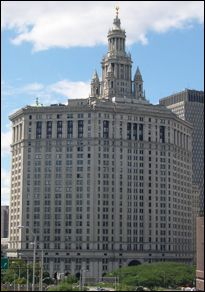

In [10]:
Image(filename=f'{root}/images/1centre.jpg')

In [0]:
root = r'/content/drive/My Drive/EnerTrac Baselining'
df_1CENTER = pd.read_excel(f'{root}/data/RTM_Export_DCAS 1 Centre Street_2016-01-01_2020-04-23_20200423181146.xlsx', 
                           header=1, 
                           index_col=0,
                           sheet_name='Data')

In [0]:
df_1CENTER['DCAS 1 Centre Street - 490118259000005'] = df_1CENTER.iloc[:, 5:11].sum(axis=1)
df_1CENTER['DCAS 1 Centre Street - 490118259100011'] = df_1CENTER.iloc[:, [12]].sum(axis=1)
df_1CENTER['DCAS 1 Centre Street (kW)'] = df_1CENTER.iloc[:, [4,11]].sum(axis=1)
df_1CENTER = df_1CENTER[['Dry-Bulb F', 'Wet-Bulb F', 'Dew-Point F', 'DCAS 1 Centre Street (kW)']]
df_1CENTER.rename(columns={'Dry-Bulb F': 'dry_bulb_temp',
                           'Wet-Bulb F': 'wet_bulb_temp',
                           'Dew-Point F': 'dew_point_temp',
                           'DCAS 1 Centre Street (kW)': 'consumption'},
                  index={'Interval End': 'time'},
                  inplace=True)

In [13]:
df_1CENTER.shape

(37790, 4)

*Check the dataframe*

In [14]:
df_1CENTER.head()

dry_bulb_temp  wet_bulb_temp  dew_point_temp  consumption
Interval End                                                                  
2016-01-01 01:00:00           42.1           34.9            26.7        922.0
2016-01-01 02:00:00           42.0           34.7            26.1        923.0
2016-01-01 03:00:00           41.3           34.3            26.3        918.0
2016-01-01 04:00:00           41.0           34.3            26.5        913.0
2016-01-01 05:00:00           41.0           34.2            26.5        914.0

Removing the NaN's (Not a Number)

In [15]:
df_1CENTER = df_1CENTER.dropna()
df_1CENTER.shape

(37729, 4)

*Pack the code into a function so we can reuse later*

In [0]:
def load_enertrac_data(root, fn):
  """
  load basic Enertrac data given the root path and the file name
  of the enertrac data
  """
  df_1CENTER = pd.read_excel(f'{root}/data/{fn}', 
                             header=1, 
                             index_col=0,
                             sheet_name='Data') 

  df_1CENTER['DCAS 1 Centre Street - 490118259000005'] = df_1CENTER.iloc[:, 5:11].sum(axis=1)
  df_1CENTER['DCAS 1 Centre Street - 490118259100011'] = df_1CENTER.iloc[:, [12]].sum(axis=1)
  df_1CENTER['DCAS 1 Centre Street (kW)'] = df_1CENTER.iloc[:, [4,11]].sum(axis=1)
  df_1CENTER = df_1CENTER[['Dry-Bulb F', 'Wet-Bulb F', 'Dew-Point F', 'DCAS 1 Centre Street (kW)']]
  df_1CENTER.rename(columns={'Dry-Bulb F': 'dry_bulb_temp',
                             'Wet-Bulb F': 'wet_bulb_temp',
                             'Dew-Point F': 'dew_point_temp',
                             'DCAS 1 Centre Street (kW)': 'consumption'},
                    index={'Interval End': 'time'},
                    inplace=True)

  df_1CENTER = df_1CENTER.dropna()

  return df_1CENTER

### Feature Engineering

**Discomfort Index**

The Discomfort Index can be expressed as

$DI = 0.4 (t_{d} + t_{w}) + 15$ 

where, 

$DI$ is the discomfort index

$t_{d}$ is the dry bulb temperature

$t_{w}$ is the wet bulb temperature

The higher the value, the more discomfortable a person feels

In [0]:
df_1CENTER['discomfort_index'] = 0.4*(df_1CENTER.dry_bulb_temp+df_1CENTER.wet_bulb_temp)+15

**Relative Humidity**

* Relative humidity (RH) is the ratio of the partial pressure of water vapor to the equilibrium vapor pressure of water at a given temperature. 
* Relative humidity depends on temperature and the pressure of the system of interest. 
* The same amount of water vapor results in higher relative humidity in cool air than warm air. 
* A related parameter is the dew point.

In [0]:
def calc_rh(row):
  dry_bulb_temp = row['dry_bulb_temp']*units.degF
  wet_bulb_temp = row['wet_bulb_temp']*units.degF
  atmos_pressure = 101325*units.pascal
  relative_humidity = relative_humidity_wet_psychrometric(dry_bulb_temperature=dry_bulb_temp,
                                                          web_bulb_temperature=wet_bulb_temp,
                                                          pressure=atmos_pressure)
  return relative_humidity

df_1CENTER['relative_humidity'] = df_1CENTER.apply(calc_rh, axis=1).astype(float)

**Day of week**

* Given the hour in the timestamp, parse the exact week day to indicate the day of week from Monday to Friday

In [0]:
df_1CENTER['day_of_week'] = df_1CENTER.index
df_1CENTER['day_of_week'] = df_1CENTER['day_of_week'].apply(lambda x: int(x.weekday()))

**Hour of day**

* Given the hour in the timestamp, parse the exact hour to indicate the hour of day

In [0]:
df_1CENTER['hour_of_day'] = df_1CENTER.index
df_1CENTER['hour_of_day'] = df_1CENTER['hour_of_day'].apply(lambda x: int(x.hour))

**Derived occupancy**

* The derived occupancy at time $t$ captures the variation in the power that depends only on the *day-of-week* (Monday to Friday) and *hour-of-day* (0,1,2,3 ..., 23h). It captures the variation in power that is independent of the ambient weather conditions. It is calculated from the actual power data.

* For example, the value of the derived occupancy for 11 AM Monday is calculated by averaging all power values within the dataset that corresponds to Monday 11 AM. 

* Similar calculations are done to find the derived occupancy for any other *day-of-week* and *time-of-day*. The derived occupancy is stored as a look-up dictionary in a normalized format

*Derived occupancy from day of week*

In [0]:
occ_dow = dict(df_1CENTER.groupby(['day_of_week'])[['consumption']].mean().reset_index().values)

def derived_occ_dow(row):
  dow = row['day_of_week'] # day of week
  return occ_dow[dow]

df_1CENTER['derived_occ_dow'] = df_1CENTER.apply(derived_occ_dow, axis=1)

*Derived occupancy from hour of the day*

In [0]:
occ_hod = dict(df_1CENTER.groupby(['hour_of_day'])[['consumption']].mean().reset_index().values)

def derived_occ_hod(row):
  hod = row['hour_of_day'] # hour of day
  return occ_hod[hod]

df_1CENTER['derived_occ_hod'] = df_1CENTER.apply(derived_occ_hod, axis=1)

**Is the day a weekday or not**
* A day is defined as a weekday if ```day_of_week``` is in ```[0,1,2,3,4]```, which corresponds to Mon, Tue, Wed, Thu and Fri
* A the day is a weekday, then it would be given a value of 1, otherwise 0
* This is a categorical variable that helps the model to quickly seperate weekdays and weekends as the energy consumptions would vary significantly

In [0]:
def check_week_day(row):
  dow = row['day_of_week']
  if dow in range(5):
    return 1
  return 0

df_1CENTER['is_weekday'] = df_1CENTER.apply(check_week_day, axis=1)

**Variable to define four seasons**

In [0]:
def find_seasons(current_date):
  years = np.arange(2016,2021)
  all_seasons = []

  for Y in years:
    seasons = [
              ('winter', (date(Y, 1, 1), date(Y, 3, 20))),
              ('spring', (date(Y, 3, 21), date(Y, 6, 20))),
              ('summer', (date(Y, 6, 21), date(Y, 9, 22))),
              ('autum', (date(Y, 9, 23), date(Y, 12, 20))),
              ('winter', (date(Y, 12, 21), date(Y, 12, 31))),
    ]

    all_seasons += seasons

  current_season = next(season for season, (start, end) in all_seasons \
                        if start <= current_date <= end)
  return current_season

df_1CENTER = df_1CENTER.reset_index()
df_1CENTER['season'] = df_1CENTER['Interval End'].apply(find_seasons)
df_1CENTER.set_index('Interval End', inplace=True, drop=True)

def is_winter(season):
  if season == 'winter':
    return 1
  return 0

def is_spring(season):
  if season == 'spring':
    return 1
  return 0

def is_summer(season):
  if season == 'summer':
    return 1
  return 0

def is_autum(season):
  if season == 'autum':
    return 1
  return 0

df_1CENTER['is_winter'] = df_1CENTER['season'].apply(is_winter)
df_1CENTER['is_spring'] = df_1CENTER['season'].apply(is_spring)
df_1CENTER['is_summer'] = df_1CENTER['season'].apply(is_summer)
df_1CENTER['is_autum'] = df_1CENTER['season'].apply(is_autum)

df_1CENTER = df_1CENTER[df_1CENTER.columns.difference(['season'])]

**Holidays**

In [0]:
holiday_dates = []

for year in np.arange(2016, 2021):
  for date, _ in holidays.UnitedStates(years=int(year)).items():
    holiday_dates.append(str(date))

df_1CENTER['is_holiday'] = [
      1 if str(val).split()[0] in holiday_dates else 0 for val in df_1CENTER.index
]

*Before we start visualizing each variable in the dataset, it's always good to do a sanity check on the dataset to identify any potential issues with the way we are doing the feature engineering. This step might look trivial but it will save us a significant amount of time if we are able to identify issues in early stages*

**Thermal Mass of the buildings**

In [0]:
thermal_mass_3 = df_1CENTER['dry_bulb_temp'].shift(3)
thermal_mass_5 = df_1CENTER['dry_bulb_temp'].shift(5)
thermal_mass_7 = df_1CENTER['dry_bulb_temp'].shift(7)
thermal_mass_12 = df_1CENTER['dry_bulb_temp'].shift(12)

df_1CENTER['thermal_mass_3'] = thermal_mass_3
df_1CENTER['thermal_mass_5'] = thermal_mass_5
df_1CENTER['thermal_mass_7'] = thermal_mass_7
df_1CENTER['thermal_mass_12'] = thermal_mass_12

df_1CENTER = df_1CENTER.dropna()

In [27]:
df_1CENTER.head()

consumption  day_of_week  ...  thermal_mass_7  thermal_mass_12
Interval End                                   ...                                 
2016-01-01 13:00:00        919.0            4  ...            40.1             42.1
2016-01-01 14:00:00        919.0            4  ...            40.0             42.0
2016-01-01 15:00:00        936.0            4  ...            39.2             41.3
2016-01-01 16:00:00        924.0            4  ...            39.1             41.0
2016-01-01 17:00:00        944.0            4  ...            39.1             41.0

[5 rows x 20 columns]

*package the code into a function so that it could be reused later*

In [0]:
def feature_engineering(df_1CENTER):
  """
  read in the loaded enertrac data and added
  engineered features in addtion to the original
  enertrac features
  """

  df_1CENTER['discomfort_index'] = 0.4*(df_1CENTER.dry_bulb_temp+df_1CENTER.wet_bulb_temp)+15

  def calc_rh(row):
    dry_bulb_temp = row['dry_bulb_temp']*units.degF
    wet_bulb_temp = row['wet_bulb_temp']*units.degF
    atmos_pressure = 101325*units.pascal
    relative_humidity = relative_humidity_wet_psychrometric(dry_bulb_temperature=dry_bulb_temp,
                                                            web_bulb_temperature=wet_bulb_temp,
                                                            pressure=atmos_pressure)
    return relative_humidity

  df_1CENTER['relative_humidity'] = df_1CENTER.apply(calc_rh, axis=1).astype(float)

  df_1CENTER['day_of_week'] = df_1CENTER.index
  df_1CENTER['day_of_week'] = df_1CENTER['day_of_week'].apply(lambda x: int(x.weekday()))

  df_1CENTER['hour_of_day'] = df_1CENTER.index
  df_1CENTER['hour_of_day'] = df_1CENTER['hour_of_day'].apply(lambda x: int(x.hour))

  def derived_occ_dow(row):
    dow = row['day_of_week'] # day of week
    return occ_dow[dow]

  occ_dow = dict(df_1CENTER.groupby(['day_of_week'])[['consumption']].mean().reset_index().values)
  df_1CENTER['derived_occ_dow'] = df_1CENTER.apply(derived_occ_dow, axis=1)

  def derived_occ_hod(row):
    hod = row['hour_of_day'] # hour of day
    return occ_hod[hod]

  occ_hod = dict(df_1CENTER.groupby(['hour_of_day'])[['consumption']].mean().reset_index().values)
  df_1CENTER['derived_occ_hod'] = df_1CENTER.apply(derived_occ_hod, axis=1)

  def check_week_day(row):
    dow = row['day_of_week']
    if dow in range(5):
      return 1
    return 0

  df_1CENTER['is_weekday'] = df_1CENTER.apply(check_week_day, axis=1)

  def find_seasons(current_date):
    years = np.arange(2016,2021)
    all_seasons = []

    for Y in years:
      seasons = [
                ('winter', (date(Y, 1, 1), date(Y, 3, 20))),
                ('spring', (date(Y, 3, 21), date(Y, 6, 20))),
                ('summer', (date(Y, 6, 21), date(Y, 9, 22))),
                ('autum', (date(Y, 9, 23), date(Y, 12, 20))),
                ('winter', (date(Y, 12, 21), date(Y, 12, 31))),
      ]

      all_seasons += seasons

    current_season = next(season for season, (start, end) in all_seasons \
                          if start <= current_date <= end)
    return current_season

  df_1CENTER = df_1CENTER.reset_index()
  df_1CENTER['season'] = df_1CENTER['Interval End'].apply(find_seasons)
  df_1CENTER.set_index('Interval End', inplace=True, drop=True)

  def is_winter(season):
    if season == 'winter':
      return 1
    return 0

  def is_spring(season):
    if season == 'spring':
      return 1
    return 0

  def is_summer(season):
    if season == 'summer':
      return 1
    return 0

  def is_autum(season):
    if season == 'autum':
      return 1
    return 0

  df_1CENTER['is_winter'] = df_1CENTER['season'].apply(is_winter)
  df_1CENTER['is_spring'] = df_1CENTER['season'].apply(is_spring)
  df_1CENTER['is_summer'] = df_1CENTER['season'].apply(is_summer)
  df_1CENTER['is_autum'] = df_1CENTER['season'].apply(is_autum)

  df_1CENTER = df_1CENTER[df_1CENTER.columns.difference(['season'])]

  holiday_dates = []

  for year in np.arange(2016, 2021):
    for date, _ in holidays.UnitedStates(years=int(year)).items():
      holiday_dates.append(str(date))

  df_1CENTER['is_holiday'] = [
        1 if str(val).split()[0] in holiday_dates else 0 for val in df_1CENTER.index
  ]

  return df_1CENTER

**Now we can plot the actual time series for each of the variables in our dataset**

Text(0, 0.5, 'Consumption kW')

Text(0, 0.5, 'temp F')

Text(0, 0.5, '')

Text(0, 0.5, '')

Text(0.5, 0, 'Date')

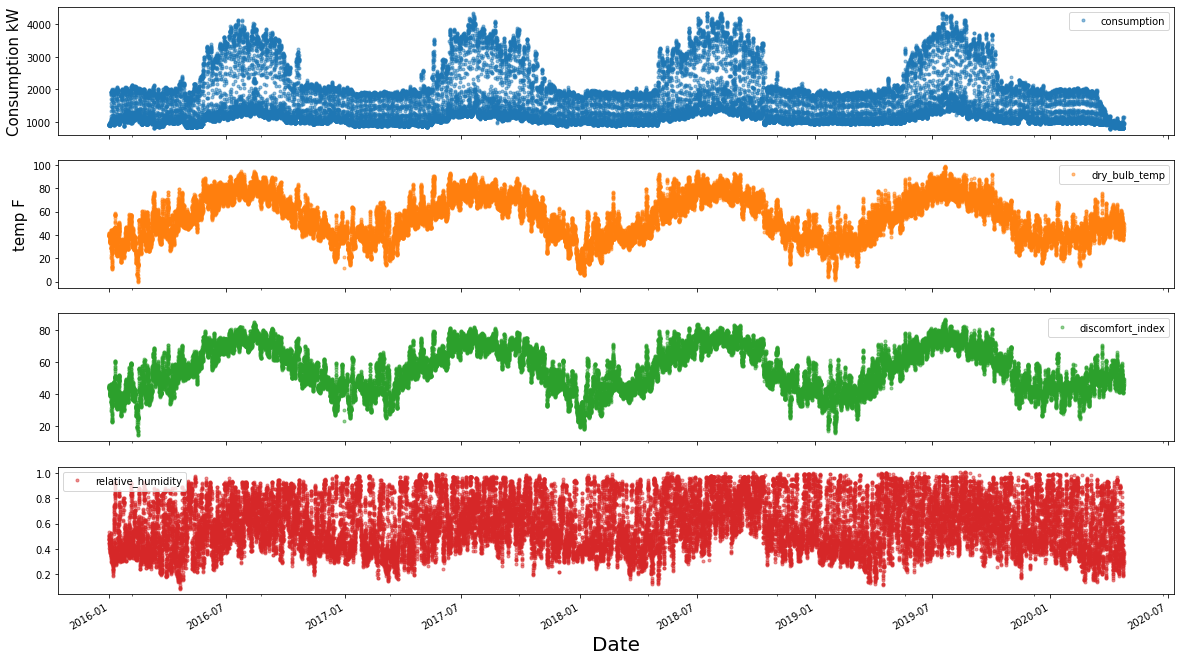

In [0]:
cols_plot = ['consumption', 'dry_bulb_temp', 'discomfort_index', 'relative_humidity']
ylabels = ['Consumption kW', 'temp F', '', '']
axes = df_1CENTER[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20,12), subplots=True)
for i, ax in enumerate(axes):
    ax.set_ylabel(ylabels[i], size=15)
plt.xlabel('Date', size=20)
plt.show()

## Statistical Model - Vector AutoRegression (VAR)

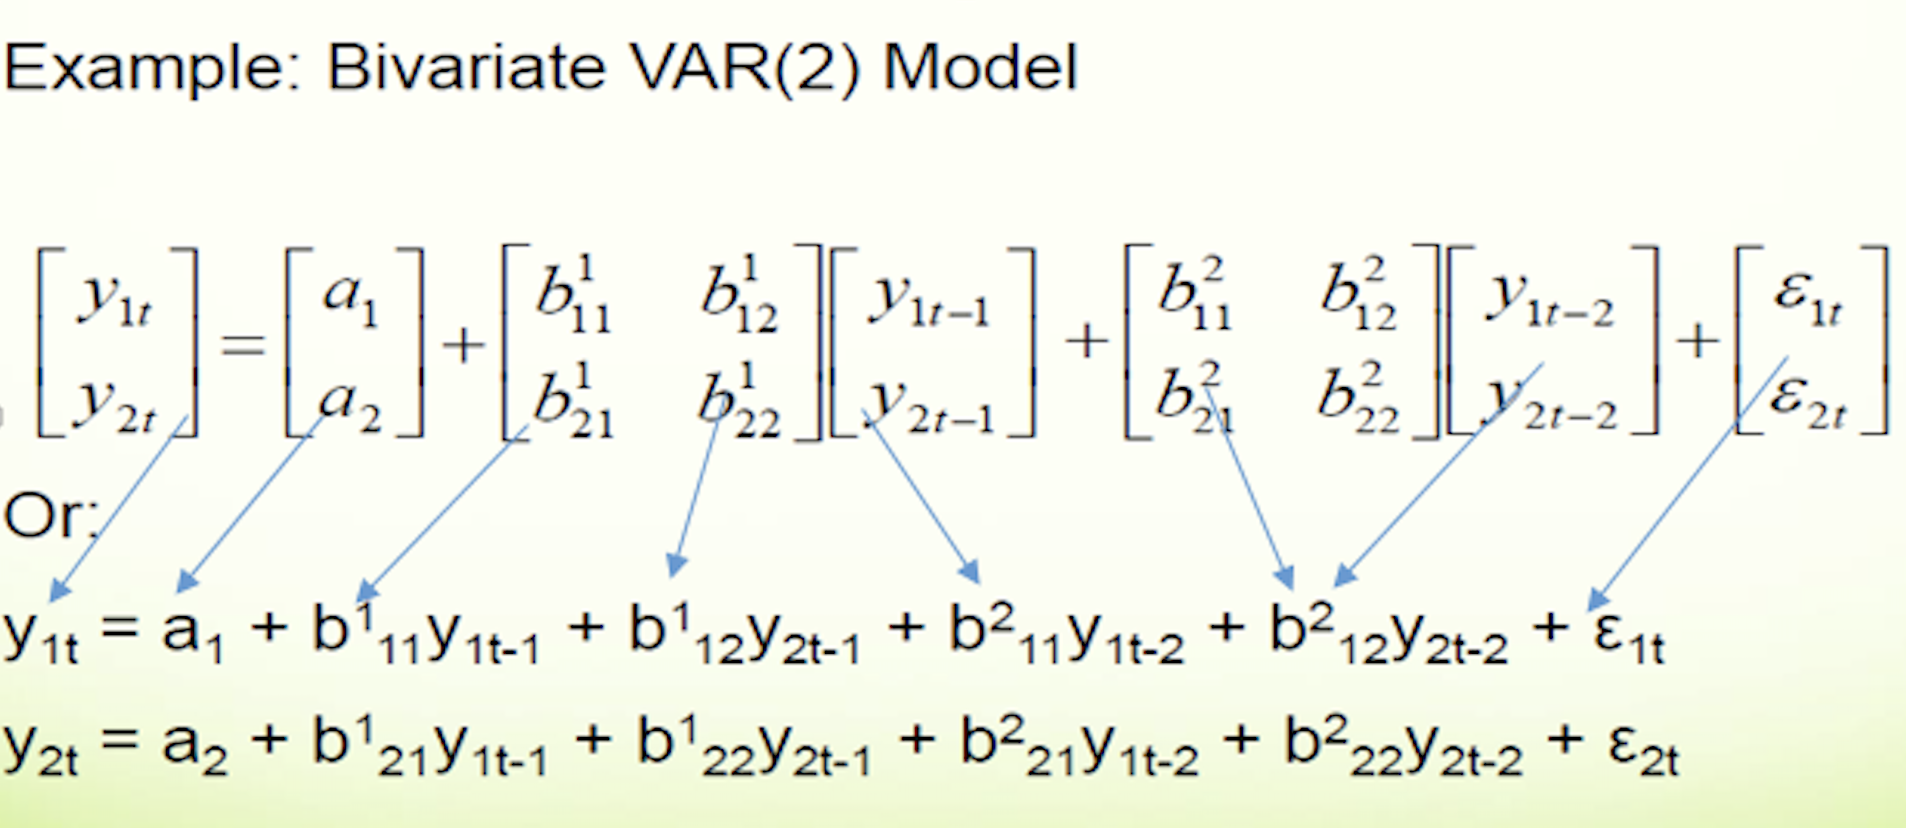

In [0]:
Image(filename=f'{root}/images/var.png', width=800, height=400)

### Exploratory Data Analysis (EDA)

This is a helper function to examine the stationarity of your variables, which is a very important assumption in VAR model

In [0]:
def tsplot(y, title, lags=None, figsize=(16,8)):
  fig = plt.figure(figsize=figsize)
  layout = (2,2)
  ts_ax = plt.subplot2grid(layout, (0,0))
  hist_ax = plt.subplot2grid(layout, (0,1))
  acf_ax = plt.subplot2grid(layout, (1,0))
  pacf_ax = plt.subplot2grid(layout, (1,1))

  y.plot(ax=ts_ax)
  ts_ax.set_title(title, fontsize=14, fontweight='bold')
  y.plot(ax=hist_ax, kind='hist', bins=25)
  hist_ax.set_title('Histogram')
  sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
  sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)

  [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
  sns.despine()
  plt.tight_layout()
  plt.show()

#### Check the stationarity of the variables 

Notion of **Stationarity**


*   A time series is said to be strictly *stationary* if the joint distributions *F($x_{t_1}$, ..., $x_{t_n}$)* and *F($x_{t_1+m}$, ..., $x_{t_n+m}$)* are the same, for every ${t_1}$, ..., ${t_n}$ and *m*. This is a very strong condition, too strong to be applied in practice; it implies that the distribution is unchanged for any time shift.
*   A weaker and more practical stationarity condition is that of weak *stationarity* (or *second order stationarity*). A time series $x_{t}$ is said to be *weakly stationary* if its mean and variance are stationary and its autocovariance *Cov($x_{t}$, $x_{t+k}$)* depends only on the time displacement $k$.

*   If a time series is second order stationary and the normality distributional assumption is imposed, then the series can be completely characterized by its mean and variance-covariance structure.



*We will only select a number of time series variables for the VARMAX model for simplicity*

In [0]:
selected_transformed_columns = ['dry_bulb_temp', 
                                'consumption', 
                                'discomfort_index', 
                                'relative_humidity']

*Check the original stationarity for every time series variable we pass into the model*

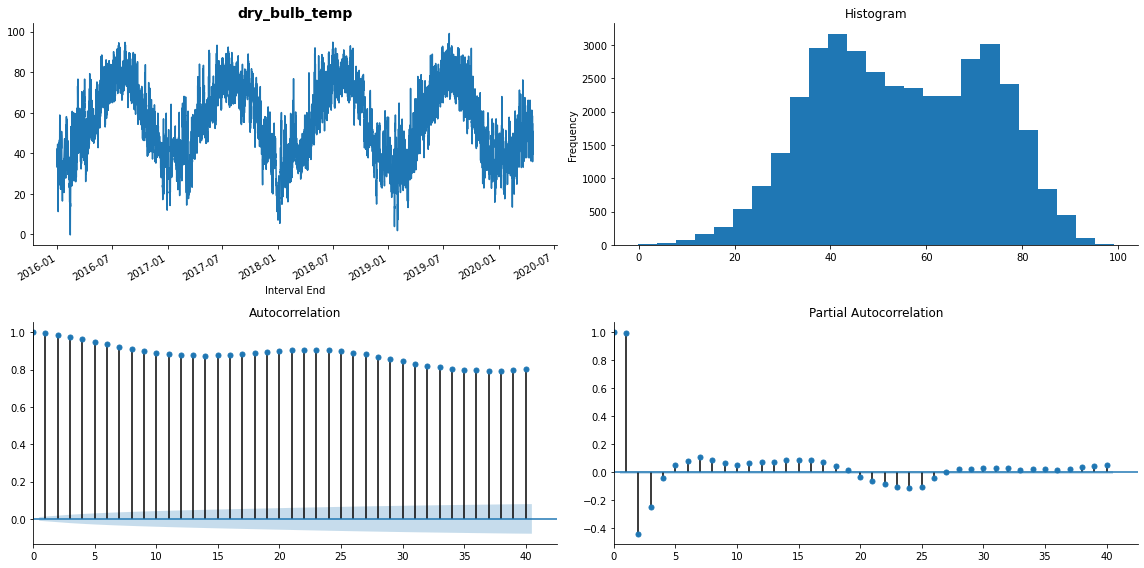

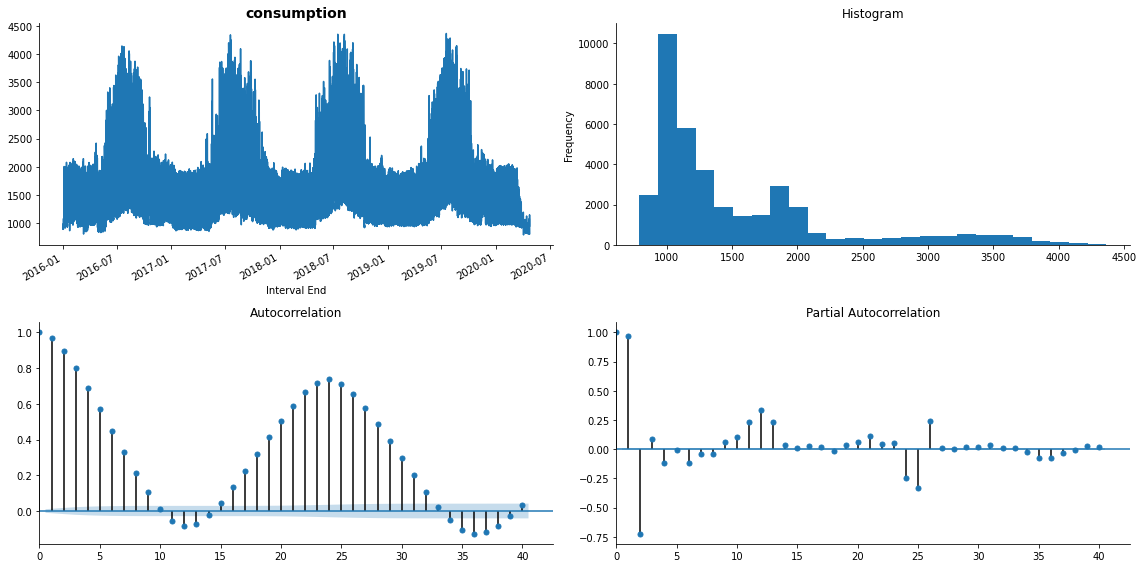

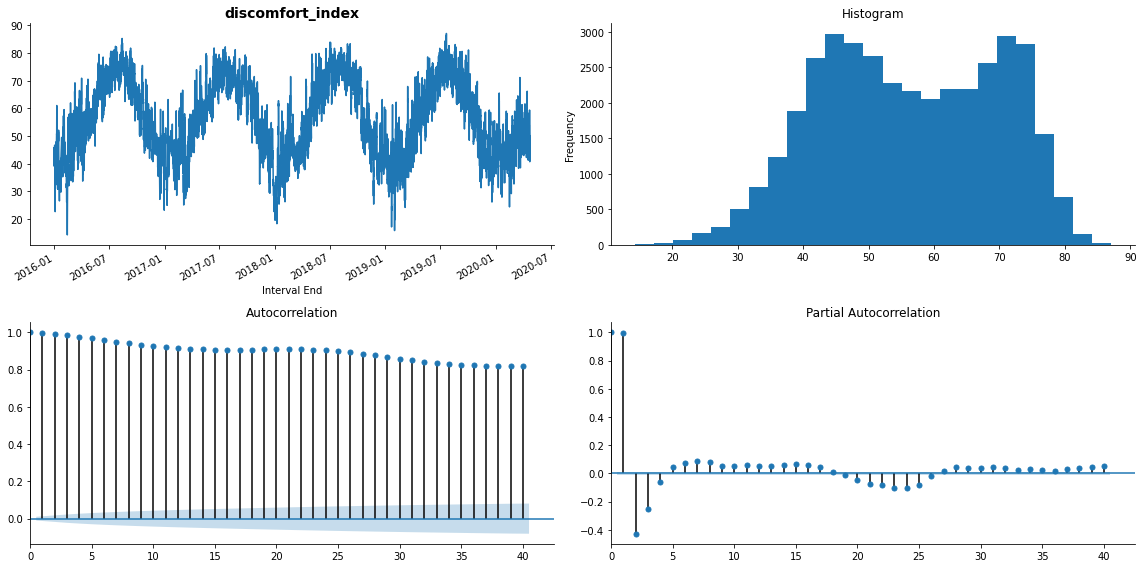

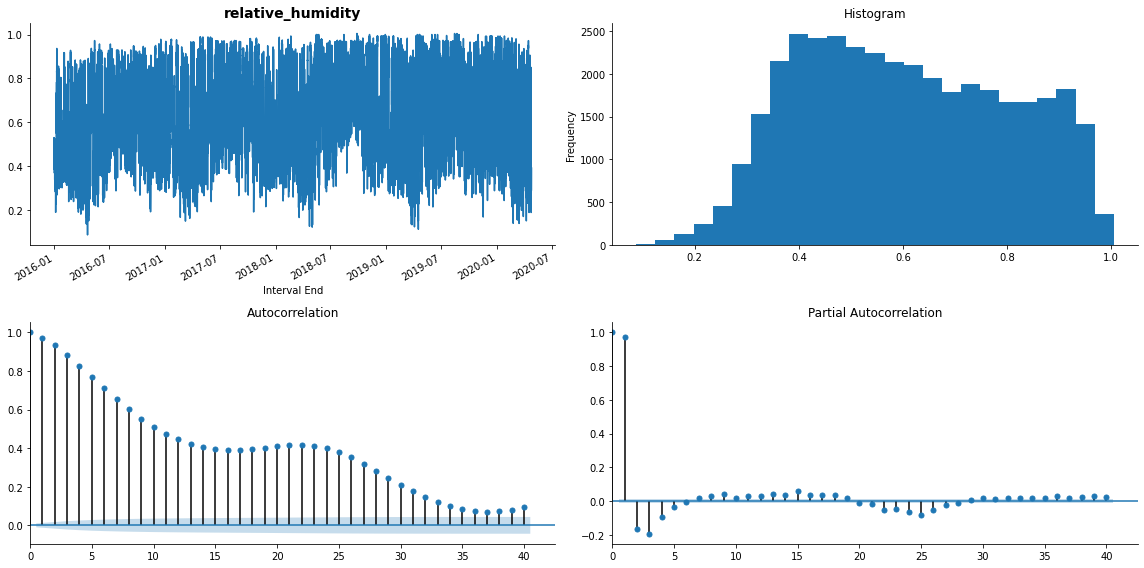

In [0]:
for col in selected_transformed_columns:
  tsplot(df_1CENTER[col], title=col, lags=40)

#### Transform the variable to make it stationary

Applying first differencing or seasonal differencing to the log of the series should make the above multiple time series stationary, a condition that is required by the VAR model

Specifically, we could try the commonly used transformation technique:

> *$log(y_{t}) - log(y_{t-l})$ = log($\frac{y_{t}}{y_{t-l}}$)*

or we can simply just apply a differencing method, the idea is to use whatever transformation that is the easiest to make sure the variables are stationary

> *$y_{t} - y_{t-l} = d$*

where *l* is some pre-defined lag. 

Some trial and error might be required to determine the right lag for your data. After you transform the time series, it's highly recommended to visualize the transformed time series to convince yourself that the time series variable is now **stationary**. 



Check the stationarity of our target variable - **consumption**

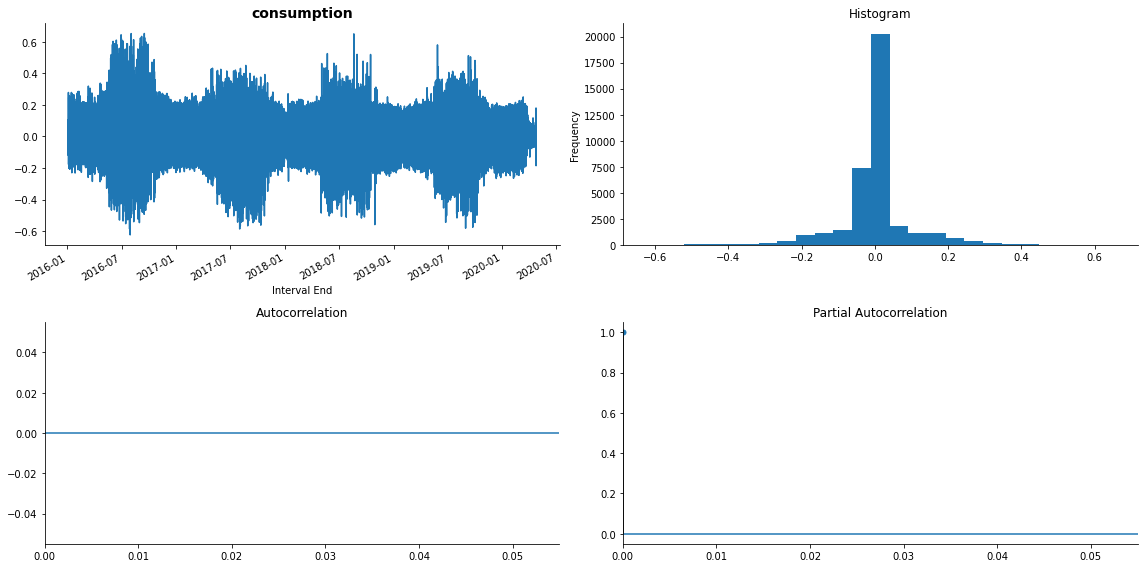

In [0]:
df_1CENTER_transformed = df_1CENTER.copy()
lag = 1
df_1CENTER_transformed['consumption'] = np.log(df_1CENTER['consumption']).diff(lag)
tsplot(df_1CENTER_transformed['consumption'], 'consumption', lags=1)

Check the stationarity of the **outside air temperature**

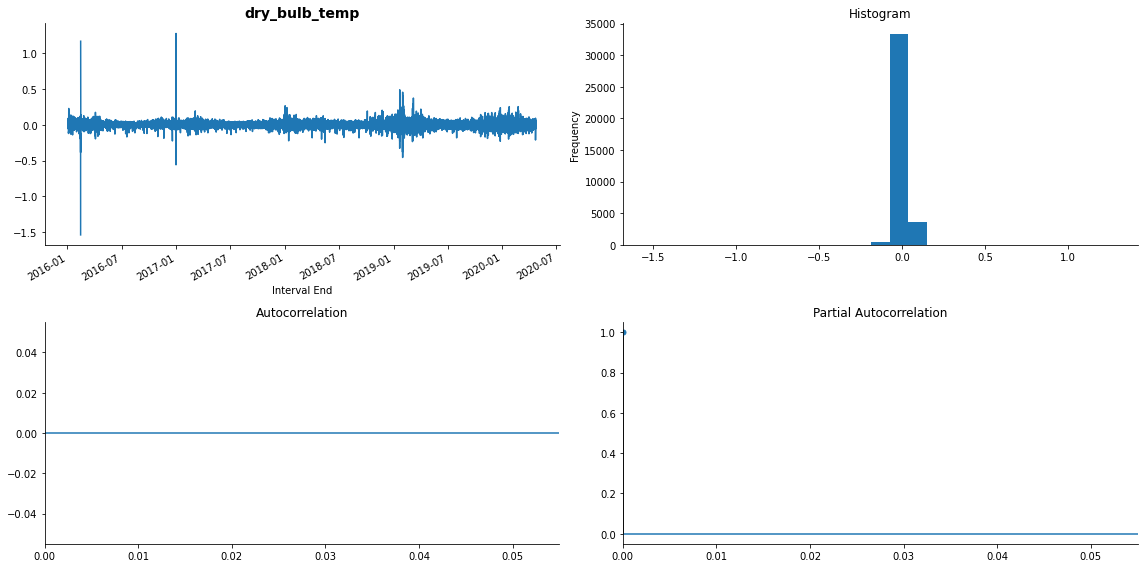

In [0]:
df_1CENTER_transformed['dry_bulb_temp'] = np.log(df_1CENTER['dry_bulb_temp']).diff(lag)
tsplot(df_1CENTER_transformed['dry_bulb_temp'], title='dry_bulb_temp', lags=1)

Check the stationarity of the **relative humidity**

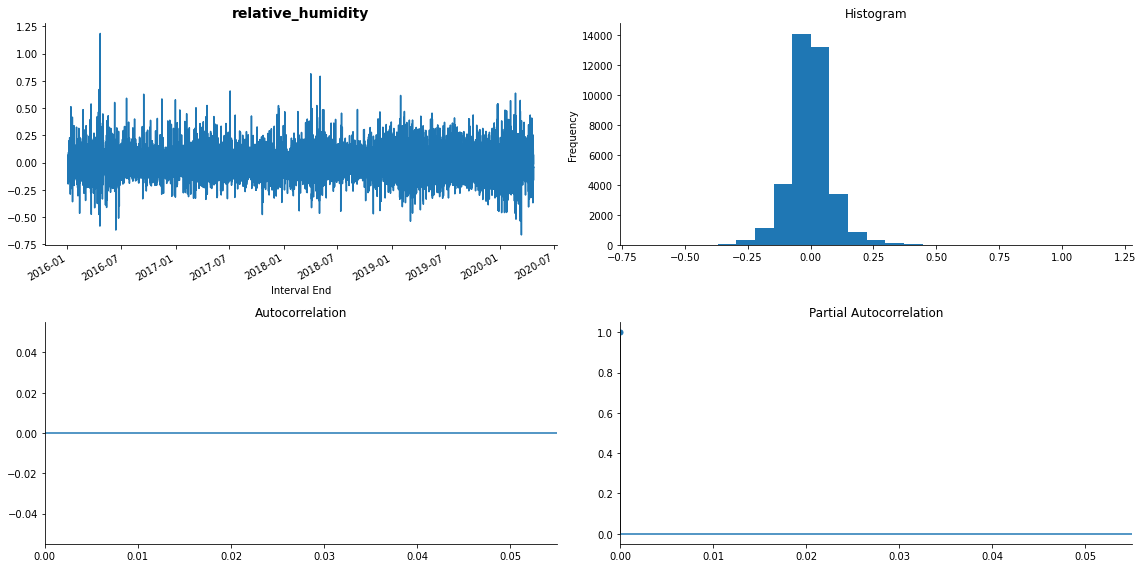

In [0]:
df_1CENTER_transformed['relative_humidity'] = np.log(df_1CENTER['relative_humidity']).diff(lag)
tsplot(df_1CENTER_transformed['relative_humidity'], title='relative_humidity', lags=1)

Check the stationarity of the **discomfort index**

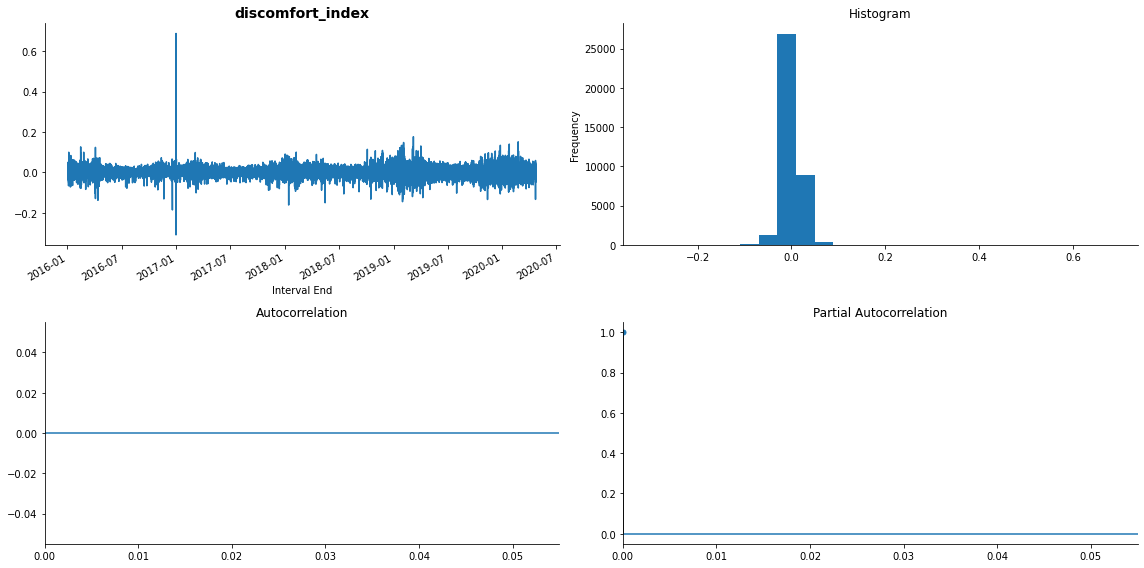

In [0]:
df_1CENTER_transformed['discomfort_index'] = np.log(df_1CENTER['discomfort_index']).diff(lag)
tsplot(df_1CENTER_transformed['discomfort_index'], title='discomfort_index', lags=1)

**Check the trainsformed dataset**

After you transform your time series variables, it's always good to go back to the dataset to confirm if the data has been shrifted by the lag you specified Due to the time constraint I was given with this project, I will not be using the entire time series variables for the VAR model, which in reality, you should. However, in order to use the entire set of time series variables, you have to make sure each individual variable is stationary, as this is a critical assumption for the VAR model to be valid. 

In [0]:
df_1CENTER_transformed = df_1CENTER_transformed[selected_transformed_columns]
df_1CENTER_transformed.head()

dry_bulb_temp  ...  relative_humidity
Interval End                        ...                   
2016-01-03 05:00:00            NaN  ...                NaN
2016-01-03 06:00:00       0.016902  ...          -0.017906
2016-01-03 07:00:00      -0.019747  ...           0.032599
2016-01-03 08:00:00      -0.011461  ...           0.040852
2016-01-03 09:00:00       0.025606  ...          -0.027237

[5 rows x 4 columns]

### Train-test split

* Since we have a significant amount of data, ranging from 2016 all the way to present 2020, with an interval of 1 hour, we can leave less data on the test set

* For example, we use 90% of our data for training, and 10% for testing

* However, unlike DCAS 1 Centre, many buildings won't have that much data to work with, some have less than a year worth data. In that case, we will need to distribute more data on the test set

* Unlike some sampling methods we use for some common regression problems where we sample the train and test data randomly, we could **NOT** use the same technique here as we need to preserve the sequence of the time series in both training and test set


In [0]:
train_test_split = 0.1
df_1CENTER_transformed = df_1CENTER_transformed.iloc[lag:]
num_data = df_1CENTER_transformed.shape[0]
num_test = int(train_test_split*num_data)

data_train, data_test = df_1CENTER_transformed[:(num_data-num_test)], df_1CENTER_transformed[(num_data-num_test):]

*Check the dimension of the datasets to see if we split the dataset correctly*

In [0]:
print(f'number of data: {num_data}, number of train: {num_data-num_test}, number of test: {num_test}')
print(f'shape of train dataset: {data_train.shape}, shape of test dataset: {data_test.shape}')

number of data: 37676, number of train: 33909, number of test: 3767
shape of train dataset: (33909, 4), shape of test dataset: (3767, 4)


### A general VAR(p) Model

A two series, VAR(1) Model


> *$y_{1,t}$ = $c_{1}$ + $\phi_{11,1}$$y_{1, t-1}$ +  $\phi_{12,1}$$y_{2, t-1}$ + $u_{1,t}$*


> *$y_{2,t}$ = $c_{2}$ + $\phi_{21,1}$$y_{1, t-1}$ +  $\phi_{22,1}$$y_{2, t-1}$ + $u_{2,t}$*

where 


*   $\phi_{ii,l}$ captures the effect of the $l^{th}$ lag of series $y_{i}$ on itself
*   $\phi_{ij,l}$ captures the effect of the $l^{th}$ lag of series $y_{j}$ on $y_{i}$

The variance-covariance matrix is 

 $$ E(u_{t}, u'_{t})\sum_{u} = \begin{pmatrix} \sum_{t}\frac{(y_{1,t}-\bar{y_{1}})^{2}}{T} & \sum_{t}\frac{(y_{1,t}-\bar{y_{1}})(y_{2,t}-\bar{y_{2}})}{T} \\ \sum_{t}\frac{(y_{2,t}-\bar{y_{1}})(y_{1,t}-\bar{y_{1}})}{T} & \sum_{t}\frac{(y_{2,t}-\bar{y_{2}})^{2}}{T} \end{pmatrix}$$

 $$ = \begin{pmatrix} Var(y_{1}) & Cov(y_{1}, y_{2}) \\ Cov(y_{2}, y_{1}) & Var(y_{2}) \end{pmatrix}$$

The constant term in each of the equations is just a constant; it is not the mean nor the long-run equilibrium of the process 

### Stationarity requirement on the series:
* VAR model is meant for stationary series; it generates stationary time series with time invariant means, variance, and covariance structure
* Stationarity assumption can be checked by autoregression plot and partial autoregression plot
* For non-stationary series that can be transformed into stationary sereis using simple differencing and if the series are not co-integrated, then we can still apply VAR in difference
* A stochastic process is said to be covariance stationary if both of its first and second moments, $E(y)$ and $\sum(y)$ exist and are constant over time. 

### Cases when VAR could be useful
* Forecasting a collection of related variables where no explicit interpretation is required
* Testing whether one variable is useful in forecasting another (the basis of Granger causality test)
* impulse response analysis, where the response is one variable to a sudden but temporary change in another variable that is analyzed
* Forecast error variance decomposition, where the proportion of the forecast variance of one variable is attributed to the effect of other variables


In [0]:
%%time
model_var = VARMAX(data_train.dropna(), order=(5,0), trend='c')
result_var = model_var.fit(maxiter=50, disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 15min 31s, sys: 10min 31s, total: 26min 2s
Wall time: 13min 14s


### Model Selection

*The way to select an order is to use information criteria AIC, BIC, HQIC. Estimate a range of models and choose the best one. The most common approach for model order selection involves minimizing one or more information criteria over a range of model orders*

*In this case, when order=5, the AIC, BIC and HQIC are minimized*

In [0]:
for i in range(1,6):
  model_var_select = VARMAX(data_train.dropna(), order=(i,0))
  model_var_result = model_var_select.fit(maxiter=50, disp=False)
  print(f'Order = {i}')
  print(f'AIC: {model_var_result.aic}')
  print(f'BIC: {model_var_result.bic}')
  print(f'HQIC: {model_var_result.hqic}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Order = 1
AIC: -474727.2250020733
BIC: -474474.2845840075
HQIC: -474646.5360760849


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Order = 2
AIC: -490327.49437299767
BIC: -489939.6523986302
HQIC: -490203.77135314874


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Order = 3
AIC: -498995.85955092905
BIC: -498473.11602025985
HQIC: -498829.10243721964


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Order = 4
AIC: -505252.4352026122
BIC: -504594.79011564126
HQIC: -505042.6439950423


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Order = 5
AIC: -509111.7100917584
BIC: -508319.1634484858
HQIC: -508858.88479032804


*Check the model summary - it gives you the coefficient of each variable*

In [0]:
print(result_var.summary())

                                                       Statespace Model Results                                                      
Dep. Variable:     ['dry_bulb_temp', 'consumption', 'discomfort_index', 'relative_humidity']   No. Observations:                33907
Model:                                                                                VAR(5)   Log Likelihood              273694.637
                                                                                 + intercept   AIC                        -547201.274
Date:                                                                       Mon, 04 May 2020   BIC                        -546408.724
Time:                                                                               01:24:05   HQIC                       -546948.448
Sample:                                                                                    0                                         
                                                              

### Model Diagnostic

*The next step is the model diagnostic and checking that he underlying assumption is true. A common overall diagnostic is the plot of residuals and to see whether the residuals obey the model assumptions.*

*We could apply tests to:*

1. *confirm normality*
2. *absence of serial correlation*
3. *absence of heteroscedasticity*

*The series does not exhibit trends or regular seasonal patterns. Therefore we can assume that they are the realization of a stationary VAR(p) process*

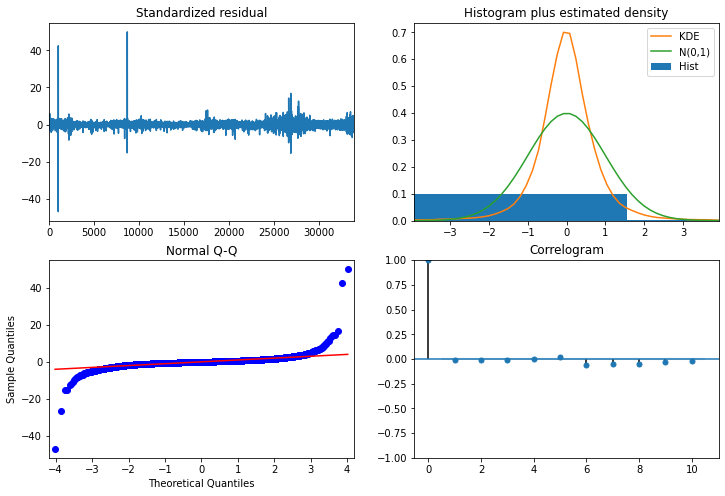

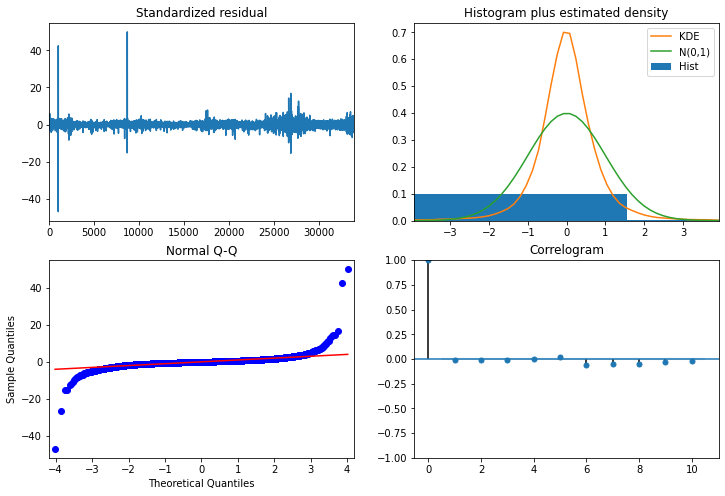

In [0]:
result_var.plot_diagnostics(figsize=(12,8))
plt.show()

### Forecast

* Remember to invert the transformation applied to the original series in order to compare the series with its original scale 
* Writing down the equations may help

In this case, the following equations would be helpful and may help minimize the chance of making mistakes 

Consider the original series: $y_{t}$

For the energy consumption series, the transformation that we made was $log(y_{t}) - log(y_{t-l})$

This is equivalent to $log(y_{t}) - log(y_{t-l}) = log(\frac{y_{t}}{y_{t-l}})$

Define $z = log(y_{t}) - log(y_{t-l})$

Then,

> $log(y_{t}) = z + log(y_{t-l})$
>
> $y_{t} = e^{z+log(y_{t-l})}$
>
> $y_{t} = e^{z}(y_{t-l})$

Therefore, we have the forecast,

> $y_{t+s} = e^{z}(y_{t-l+s})$

where $s > 1$ and $l$ is the lag

Or, in a simple differencing case, where we define $d = y_{t} - y_{t-l}$

Then,

> $y_{t} = d + y_{t-l}$

Thus, we have the forecast,

> $y_{t+s} = d + y_{t-l+s}$



*Check the number of total predictions needed to be made on the test set*

In [0]:
z = result_var.predict()['consumption'].values
z.shape

(33907,)

*now, we have to trace back the original train dataset based on the dimension of the transformed train set. Comfirm the number by checking the previous dimension*

In [0]:
data_train_trace = df_1CENTER['consumption'].iloc[lag:num_data-num_test-1]
data_train_trace.shape

(33907,)

*also, we need to trace back the test set based on the original dimension, make sure this number is equal to the number of predictions we are going to make*

In [0]:
data_test_trace = df_1CENTER['consumption'].iloc[lag:][num_data-num_test:]
data_test_trace.shape

(3767,)

*perform the reverse transformation based on the data in train set as well as z, which is the differencing factor*

In [0]:
predictions = data_train_trace.values*np.exp(z)
num_predictions = data_test_trace.shape[0]
predictions = predictions[:num_predictions]
predictions.shape

(3767,)

*For some reason, the prediction seems a little bit shifted and it's also not very accurate when it comes to predicting the COVID-19 period*

*In terms of why, there could be many speculations, maybe the statistical tests are not conducted rigorously enough*

*This could be an interesting project for future iterations, which is to come up with a more robust method of evaluating our assumptions, or try to test out different lagging factors when we are transforming the time series to be stationary*

Text(0, 0.5, 'Energy Consumption')

Text(0.5, 0, 'Date time')

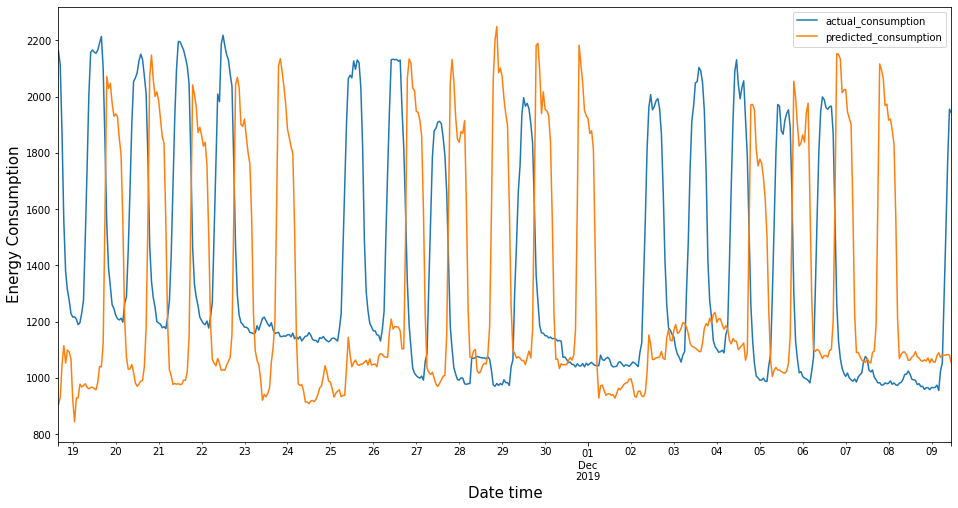

In [0]:
final_results = pd.DataFrame(data_test_trace)
final_results.rename(columns={'consumption': 'actual_consumption'}, inplace=True)
final_results['predicted_consumption'] = predictions
# final_results['predicted_consumption'] = final_results['predicted_consumption'].shift(-10)
final_results.head(500).plot(figsize=(16,8))
plt.ylabel('Energy Consumption', fontsize=15)
plt.xlabel('Date time', fontsize=15)
plt.show()

### Model Evaluation

Root Mean Squared Error: 

RMSE = $\sqrt{\frac{1}{L}\sum_{l=1}^{L}(y_{T+l}-\hat{y}_{T+l})^2}$

where $T$ is the last observation period and $l$ is the lag

In [0]:
final_results = final_results.dropna()
rmse_var = math.sqrt(mean_squared_error(final_results['actual_consumption'], final_results['predicted_consumption']))
print(f'test RMSE: {rmse_var}')

test RMSE: 644.2692385963168


*put it into context, how much error it is relative to the mean of the actual energy consumption for the test dataset*

In [0]:
mean_consump = final_results['actual_consumption'].mean()
print(f'energy consumption - percentage error relative to the mean: {rmse_var/mean_consump}')

energy consumption - percentage error relative to the mean: 0.525034032187005


## Deep Neural Network - Long Short-Term Memory (LSTM)

For more details related to the mechanism of LSTM, please review this very helpful [post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

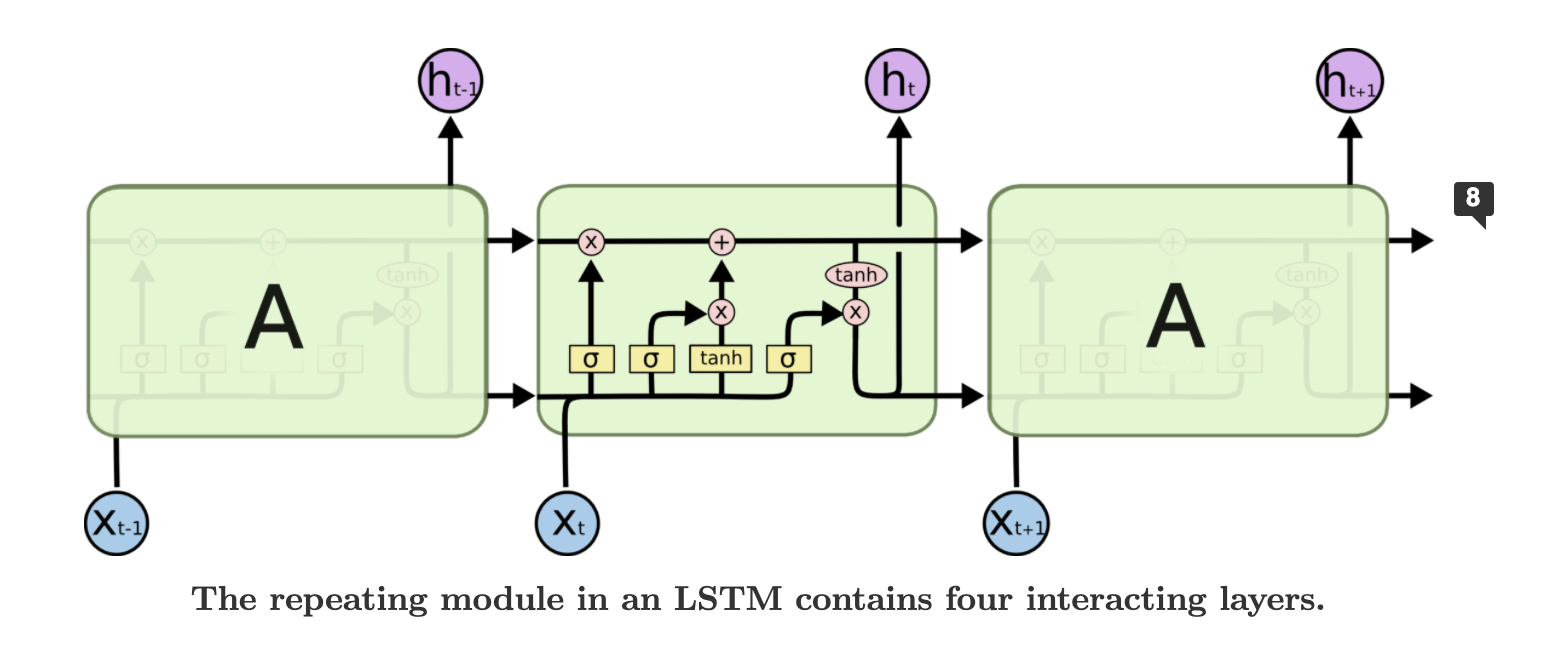

In [0]:
Image(filename=f'{root}/images/lstm.png', width=1000, height=400)

### Target Data for Prediction

*the time series variable we are trying to predict*

In [0]:
target_names = ['consumption']

*If you want to predict the energy consumption for the next 2 days, we have to shift the data $24\times{2}$ time-steps. If we want to predict the energy consumption for next week, we need to shift the data 7 days, which is $24\times{7}$ time steps*

In [0]:
shift_days = 2
shift_steps = shift_days*24

*Note that you are predicting the future NOT the past*

In [0]:
df_1CENTER_target = df_1CENTER[target_names].shift(-shift_steps)

*Shift the features*

In [0]:
x_data = df_1CENTER.values[0:-shift_steps]

In [0]:
x_data.shape

(37681, 15)

*Shift the target*

In [0]:
y_data = df_1CENTER_target.values[0:-shift_steps]

In [0]:
y_data.shape

(37681, 1)

*Total number of the entire dataset*

In [0]:
num_data = len(x_data)
num_data

37681

*If you have a significant amount of data to work with, you can split more data for training; however, certain buildings have data less than a year, in that case, 0.2-0.3 of the entire dataset allocated to test set would be better*

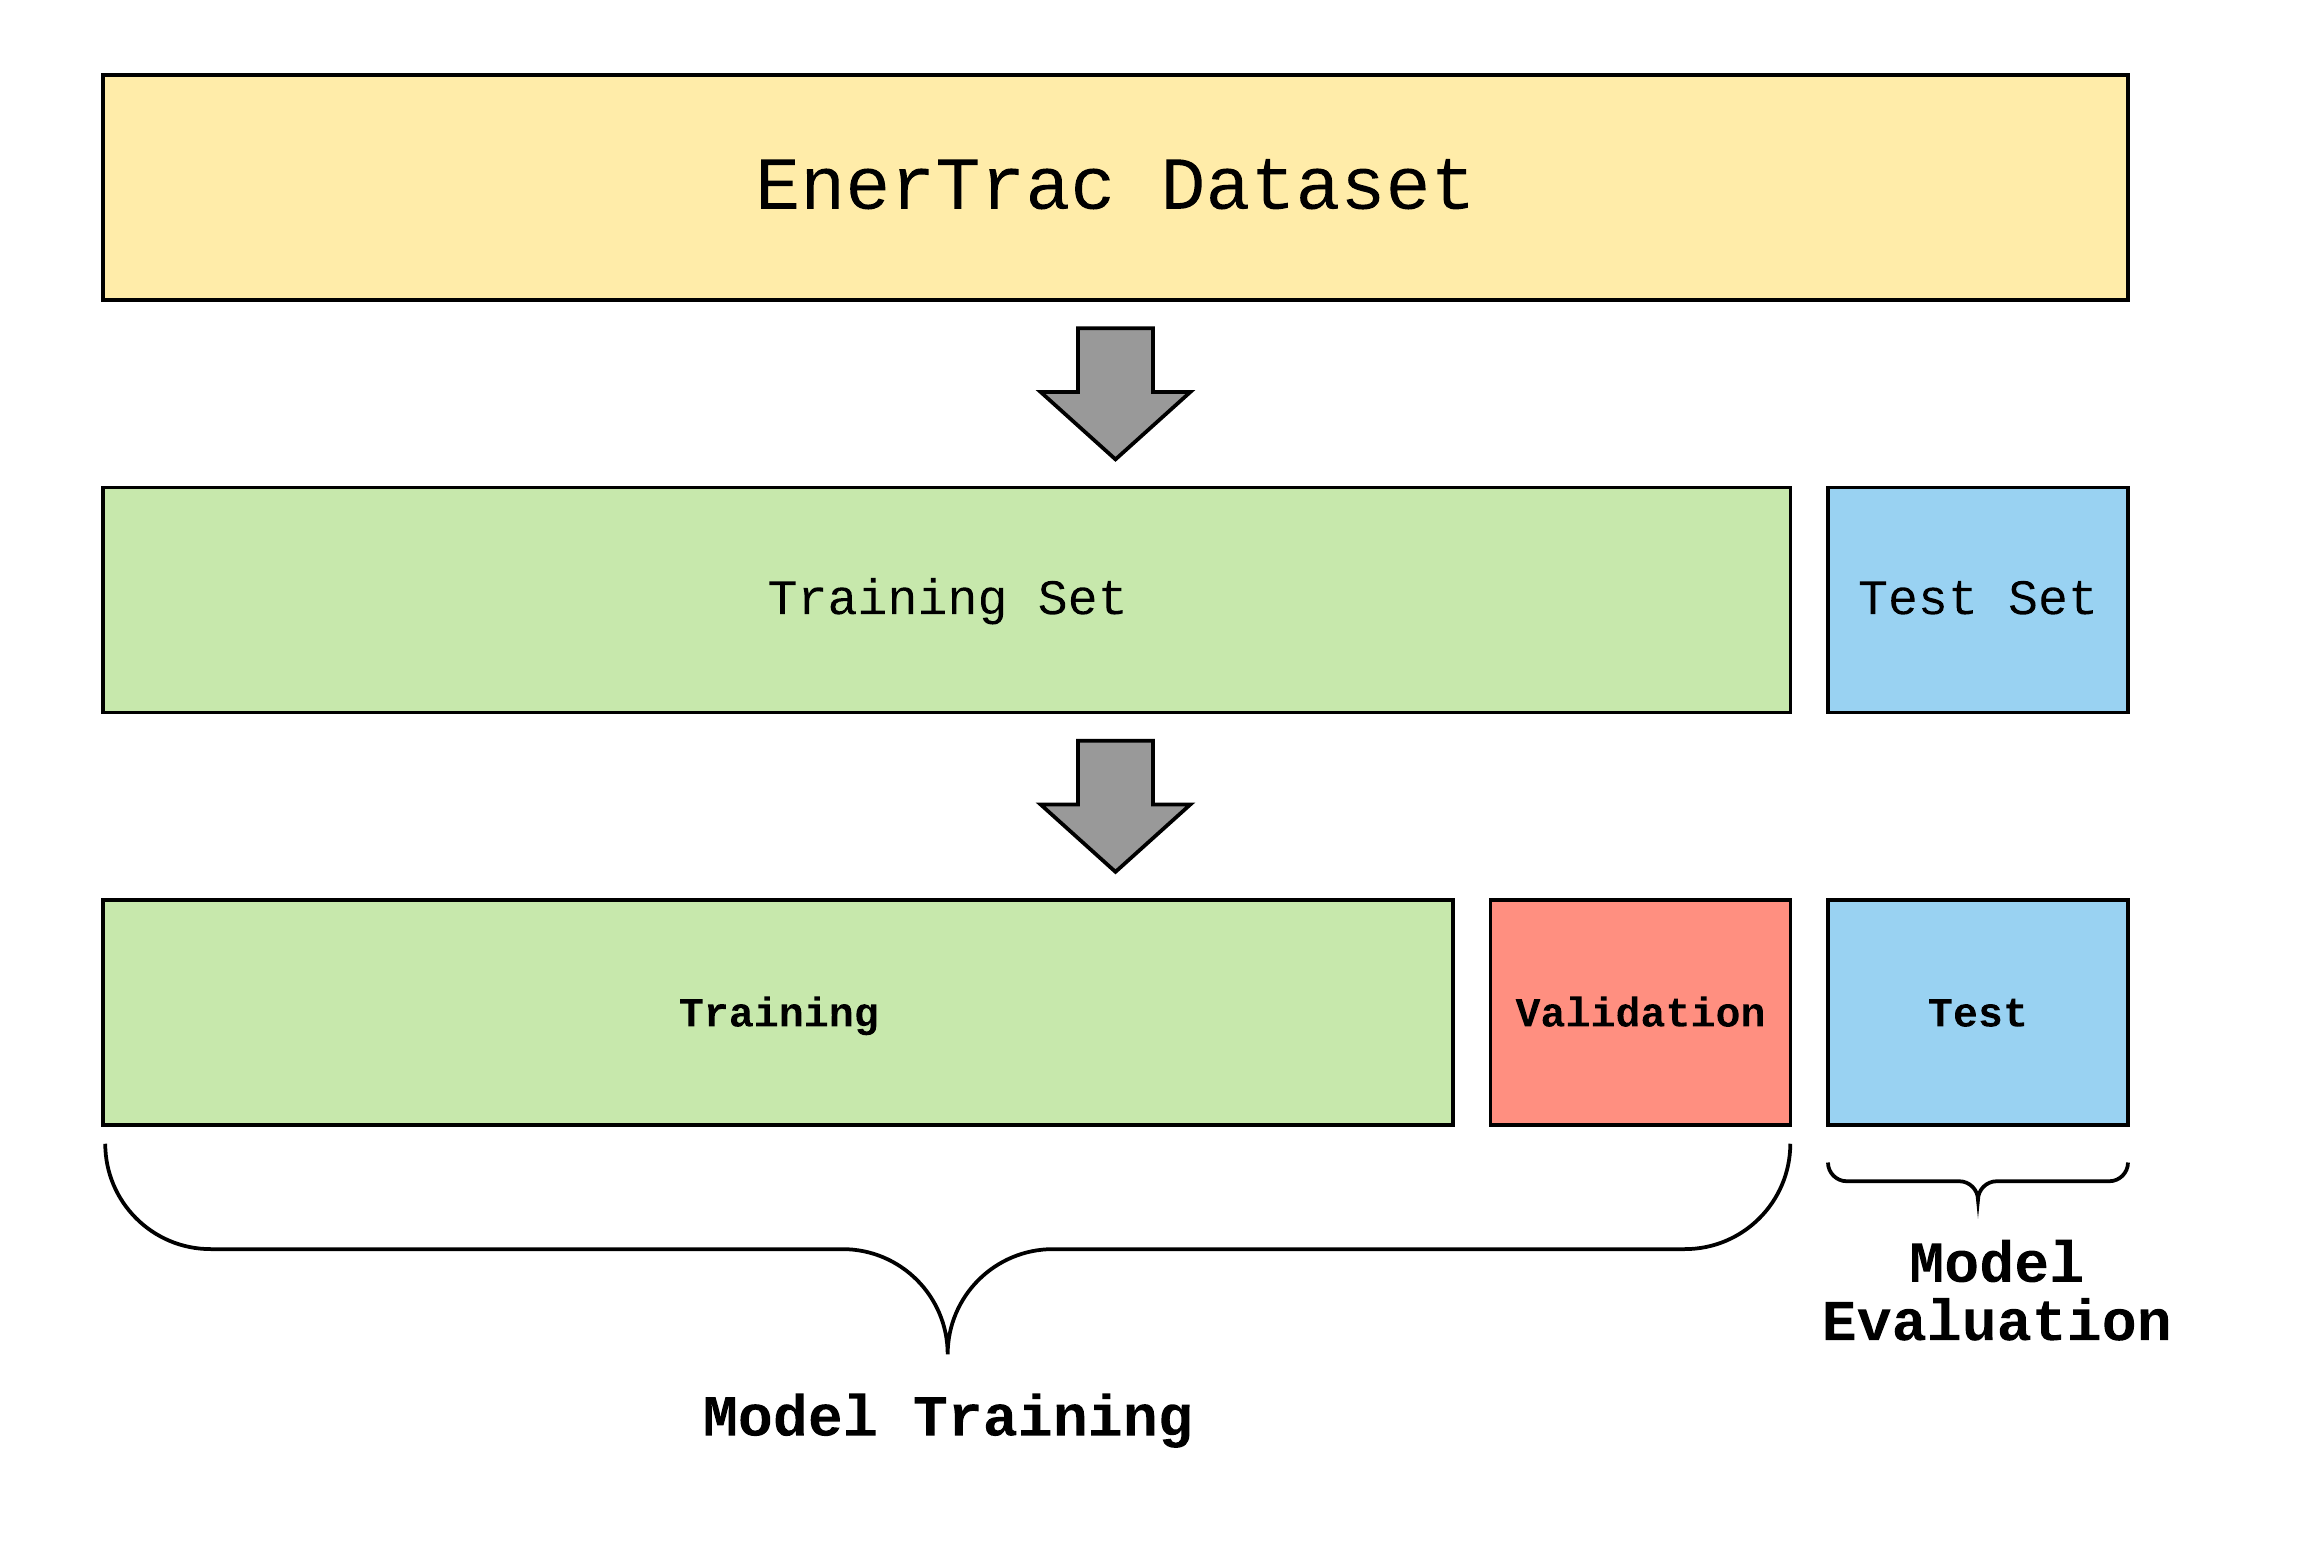

In [0]:
Image(filename=f'{root}/images/datasplit.png', width=800, height=600)

In [0]:
train_split = 0.9

*Check the actual size of training dataset*

In [0]:
num_train = int(train_split*num_data)
num_train

33912

*Check the actual number of the test dataset*

In [0]:
num_test = num_data - num_train
num_test

3769

*See if the numbers add up to the total size of the dataset, split the data for training and testing for the features*

In [0]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train)+len(x_test)

37681

*Split the data for training and testing for the target variable*

In [0]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train)+len(y_test)

37681

*Further, we need to split a portion of the train dataset for validation*

In [0]:
validation_split = 0.1

*Size of the validation dataset*

In [0]:
num_validation = int(validation_split*num_train)
num_validation

3391

*Size of the updated training data*

In [0]:
num_train = num_train - num_validation
num_train

30521

*Split the data for training and validation for the features*

In [0]:
x_validation = x_train[num_train:]
x_train = x_train[:num_train]
len(x_train)+len(x_validation)

33912

*Split the data for training and validation for the target*

In [0]:
y_validation = y_train[num_train:]
y_train = y_train[:num_train]
len(y_train)+len(y_validation)

33912

*The number of features*

In [0]:
num_x_signals = x_data.shape[1]
num_x_signals

15

*The number of target*

In [0]:
num_y_signals = y_data.shape[1]
num_y_signals

1

*pack the code into a reusable function*

In [0]:
def prepare_data(df_1CENTER):
  """
  train, validation and test data split
  """
  target_names = ['consumption']
  shift_days = 2
  shift_steps = shift_days*24

  df_1CENTER_target = df_1CENTER[target_names].shift(-shift_steps)
  x_data = df_1CENTER.values[0:-shift_steps]
  y_data = df_1CENTER_target.values[0:-shift_steps]
  indices = df_1CENTER[0:-shift_steps].index

  num_data = len(x_data)
  train_split = 0.9
  num_train = int(train_split*num_data)
  num_test = num_data - num_train

  x_train = x_data[0:num_train]
  x_test = x_data[num_train:]

  y_train = y_data[0:num_train]
  y_test = y_data[num_train:]

  validation_split = 0.1
  num_validation = int(validation_split*num_train)
  num_train = num_train - num_validation

  x_validation = x_train[num_train:]
  x_train = x_train[:num_train]

  y_validation = y_train[num_train:]
  y_train = y_train[:num_train]

  num_x_signals = x_data.shape[1]
  num_y_signals = y_data.shape[1]

  return x_data, \
         x_train, \
         x_validation, \
         x_test, \
         y_data, \
         y_train, \
         y_validation, \
         y_test, \
         num_x_signals, \
         num_y_signals, \
         num_train, \
         indices

### Data Scaling

*The original variables are in different scale, this will make the LSTM hard to put on weights on the variables*

In [0]:
print(f'Min: {np.min(x_train)}, Max: {np.max(x_train)} (Training dataset)')

Min: -18.1, Max: 4352.0 (Training dataset)


*The neural network works best on values roughly between 0 to 1, so we need to scale the data before inputting it into the neural network*

In [0]:
x_scaler = MinMaxScaler()

*Scale the train data from 0 to 1*

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

*Scale the test data from 0 to 1*

In [0]:
x_test_scaled = x_scaler.transform(x_test)

*Scale the validation data from 0 to 1*

In [0]:
x_validation_scaled = x_scaler.transform(x_validation)

In [0]:
print(f'Min: {np.min(x_train_scaled)}, Max: {np.max(x_train_scaled)}')

Min: 0.0, Max: 1.0000000000000002


*We have to apply the same scaling technique on the target data*

In [0]:
y_scaler = MinMaxScaler()

In [0]:
y_train_scaled = y_scaler.fit_transform(y_train)

In [0]:
y_test_scaled = y_scaler.transform(y_test)

In [0]:
y_validation_scaled = y_scaler.transform(y_validation)

*pack the code into a reusable function*

In [0]:
def scale_data(x_data,
               x_train, 
               x_validation,
               x_test,
               y_data, 
               y_train, 
               y_validation,
               y_test):
  """
  use min max scaling method to scale the data
  """

  x_scaler = MinMaxScaler()
  x_data_scaled = x_scaler.fit_transform(x_data)
  x_train_scaled = x_scaler.fit_transform(x_train)
  x_test_scaled = x_scaler.transform(x_test)
  x_validation_scaled = x_scaler.transform(x_validation)

  y_scaler = MinMaxScaler()
  y_data_scaled = y_scaler.fit_transform(y_data)
  y_train_scaled = y_scaler.fit_transform(y_train)
  y_test_scaled = y_scaler.transform(y_test)
  y_validation_scaled = y_scaler.transform(y_validation)

  return x_data_scaled, \
         x_train_scaled, \
         x_validation_scaled, \
         x_test_scaled, \
         y_data_scaled, \
         y_train_scaled, \
         y_validation_scaled, \
         y_test_scaled, \
         y_scaler

### Data Generator

*The dataset has been scaled into a 2D array, the training data has 30k observations, with 11 features*

In [0]:
print(x_train_scaled.shape)

(30521, 15)


In [0]:
print(y_train_scaled.shape)

(30521, 1)


*Instead of training the LSTM on the complete sequences for almost 30k observations, we can use the following function to create a batch of shorted sub-sequences picked at random from the training data* 

In [0]:
def batch_generator(batch_size, sequence_length):
  while True:
    x_shape = (batch_size, sequence_length, num_x_signals)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    y_shape = (batch_size, sequence_length, num_y_signals)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)

    for i in range(batch_size):
      idx = np.random.randint(num_train-sequence_length)

      x_batch[i] = x_train_scaled[idx: idx+sequence_length]
      y_batch[i] = y_train_scaled[idx: idx+sequence_length]
    
    yield (x_batch, y_batch)

In [0]:
batch_size = 128

In [0]:
sequence_length = 24*7*5
sequence_length

840

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
x_batch.shape

(128, 840, 15)

In [0]:
y_batch.shape

(128, 840, 1)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'time step')

Text(0, 0.5, 'signal')

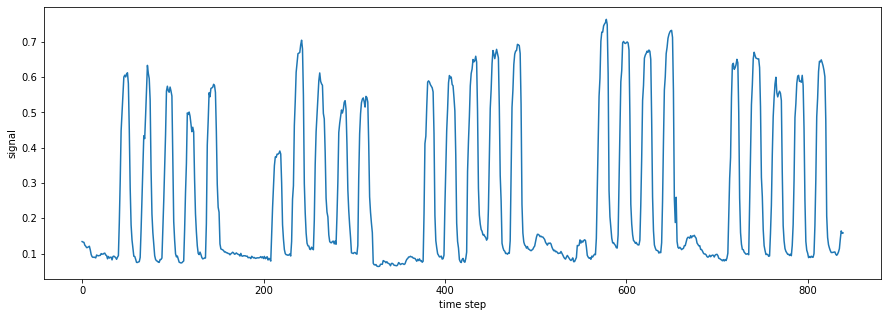

In [0]:
batch = 0
signal = 0
seq_x = x_batch[batch, :, signal]
plt.figure(figsize=(15,5))
plt.plot(seq_x)
plt.xlabel('time step')
plt.ylabel('signal')
plt.show()

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'time step')

Text(0, 0.5, 'signal')

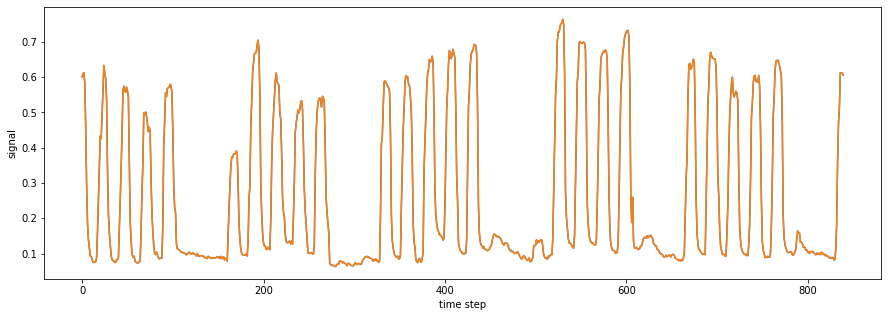

In [0]:
seq_y = y_batch[batch, :, signal]
plt.figure(figsize=(15,5))
plt.plot(seq_y)
plt.xlabel('time step')
plt.ylabel('signal')
plt.plot(seq_y)
plt.show()

*pack the batch generator code into a function for later use*

In [0]:
def data_generator(x_train_scaled, 
                   y_train_scaled,
                   num_x_signals,
                   num_y_signals,
                   num_train):
  
  """
  generate the batches for LSTM model training
  """
  def batch_generator(batch_size, 
                      sequence_length, 
                      x_train_scaled, 
                      y_train_scaled,
                      num_x_signals,
                      num_y_signals,
                      num_train):
    while True:
      x_shape = (batch_size, sequence_length, num_x_signals)
      x_batch = np.zeros(shape=x_shape, dtype=np.float16)

      y_shape = (batch_size, sequence_length, num_y_signals)
      y_batch = np.zeros(shape=y_shape, dtype=np.float16)

      for i in range(batch_size):
        idx = np.random.randint(num_train-sequence_length)

        x_batch[i] = x_train_scaled[idx: idx+sequence_length]
        y_batch[i] = y_train_scaled[idx: idx+sequence_length]
      
      yield (x_batch, y_batch)

  batch_size = 128
  sequence_length = 24*7*5

  generator = batch_generator(batch_size=batch_size, 
                              sequence_length=sequence_length,
                              x_train_scaled=x_train_scaled, 
                              y_train_scaled=y_train_scaled,
                              num_x_signals=num_x_signals,
                              num_y_signals=num_y_signals,
                              num_train=num_train)

  x_batch, y_batch = next(generator)
  return x_batch, y_batch

### Validation Dataset

In [0]:
validation_data = (np.expand_dims(x_validation_scaled, axis=0), np.expand_dims(y_validation_scaled, axis=0))

*pack it into a reusable function*

In [0]:
def validation_data_generator(x_validation_scaled, y_validation_scaled):
  validation_data = (np.expand_dims(x_validation_scaled, axis=0), np.expand_dims(y_validation_scaled, axis=0))
  return validation_data

### Build a Recurrent Neural Network (RNN)
- LSTM (Long Short-Term Memory)
- Basic Architecture (without hyper-parameter tuning)

In [0]:
model_lstm = Sequential()

model_lstm.add(
    LSTM(units=256,
         return_sequences=True,
         dropout=0.1,
         recurrent_dropout=0.2,
         input_shape=(None, num_x_signals,)
))

model_lstm.add(Dense(num_y_signals, activation='sigmoid'))

### Loss Function

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):

  y_true_slice = y_true[:, warmup_steps:, :]
  y_pred_slice = y_pred[:, warmup_steps:, :]

  mse = mean(square(y_true_slice - y_pred_slice))

  return mse

### Metrics

In [0]:
def NRMSD(y_true, y_pred):
  return sqrt(mean(square(y_pred-y_true))) / mean(y_true)

def mean_forecast_error(y_true, y_pred):
  return mean(y_true-y_pred)

metrics = ['mse', 'mae', 'mape', NRMSD, mean_forecast_error]

**Load pre-stored model so you can skip the deep neural network training process**

In [0]:
model_lstm = load_model(f'{root}/models/lstm_model.h5', 
                        custom_objects={'loss_mse_warmup': loss_mse_warmup, 
                                        'NRMSD': NRMSD,
                                        'mean_forecast_error': mean_forecast_error})

*pack the model loading process into a reusable function*

In [0]:
def load_lstm_model(root, model_name):
  """
  load the pre-stored LSTM model
  """

  def loss_mse_warmup(y_true, y_pred):
    warmup_steps = 50
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))
    return mse

  def NRMSD(y_true, y_pred):
    return sqrt(mean(square(y_pred-y_true))) / mean(y_true)

  def mean_forecast_error(y_true, y_pred):
    return mean(y_true-y_pred)

  model_lstm = load_model(f'{root}/models/{model_name}', 
                          custom_objects={'loss_mse_warmup': loss_mse_warmup, 
                                          'NRMSD': NRMSD,
                                          'mean_forecast_error': mean_forecast_error})

  return model_lstm

### Compile Model

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model_lstm.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=metrics)

In [0]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         278528    
_________________________________________________________________
dense (Dense)                (None, None, 1)           257       
Total params: 278,785
Trainable params: 278,785
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [0]:
path_checkpoint = 'lstm_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weitghts_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./lstm_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

### Train LSTM
* Please note that it takes more than 8 hours without tuning

In [0]:
%%time
history = model_lstm.fit(x=generator,
                         epochs=20,
                         steps_per_epoch=100,
                         validation_data=validation_data,
                         callbacks=callbacks)

Epoch 1/20
  3/100 [..............................] - ETA: 11:21 - loss: 0.0766 - mse: 0.0768 - mae: 0.2257 - mape: 5396.1309 - NRMSD: 1.3059 - mean_forecast_error: -0.0864

### Load Checkpoint

In [0]:
try:
  model_lstm.load_weights(path_checkpoint)
except Exception as e:
  print('Error in loading checkpoint')
  print(e)

### Metrics Evaluation

A notion of **overfitting**

In [0]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mae', 'mape', 'NRMSD', 'mean_forecast_error', 'val_loss', 'val_mse', 'val_mae', 'val_mape', 'val_NRMSD', 'val_mean_forecast_error', 'lr'])


Might be underfitting, model performance could be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers. 

However, expanding the capacity of the model may increase the runtime significantly, so there's time and performance tradeoff you have to make for future development. 

In most cases, the very time-consuming hyper-parameter tuning process should stop at the point when you spend a significant amount of time in training in exchange for little to nothing improvement in model performance. 

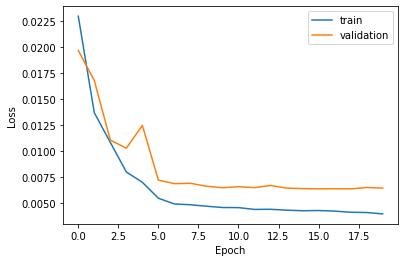

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

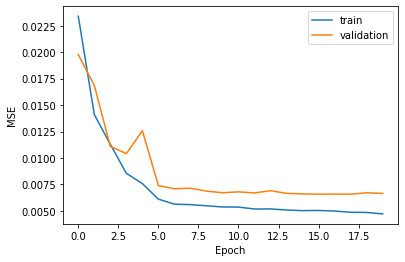

In [0]:
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

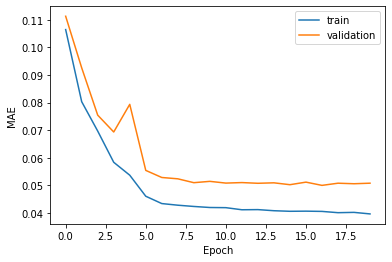

In [0]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

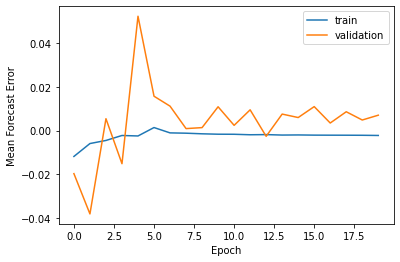

In [0]:
plt.plot(history.history['mean_forecast_error'], label='train')
plt.plot(history.history['val_mean_forecast_error'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Forecast Error')
plt.legend()
plt.show()

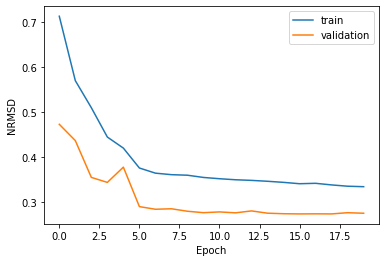

In [0]:
plt.plot(history.history['NRMSD'], label='train')
plt.plot(history.history['val_NRMSD'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSD')
plt.legend()
plt.show()

### Train Dataset Performance

In [0]:
result_lstm_train = model_lstm.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                                        y=np.expand_dims(y_train_scaled, axis=0))

1/1 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 1574.7931 - NRMSD: 0.2913 - mean_forecast_error: 0.0050


In [0]:
print(f'loss in train dataset = {result_lstm_train[0]}')

loss in train dataset = 0.003660944988951087


In [0]:
for res, metric in zip(result_lstm_train, model_lstm.metrics_names):
  print(f'{metric}: {res}')

loss: 0.003660944988951087
mean_squared_error: 0.0036733655724674463
mean_absolute_error: 0.034402623772621155
mean_absolute_percentage_error: 1574.7930908203125
NRMSD: 0.2913242280483246
mean_forecast_error: 0.004976821132004261


### Test Dataset Performance

In [0]:
result_lstm = model_lstm.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                                  y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 113.8700 - NRMSD: 0.5424 - mean_forecast_error: -0.0107


In [0]:
print(f'loss in test dataset = {result_lstm[0]}')

loss in test dataset = 0.004161861725151539


Other metrics

In [0]:
for res, metric in zip(result_lstm, model_lstm.metrics_names):
  print(f'{metric}: {res}')

loss: 0.004161861725151539
mean_squared_error: 0.0041591511107981205
mean_absolute_error: 0.03617103397846222
mean_absolute_percentage_error: 113.87002563476562
NRMSD: 0.5423907041549683
mean_forecast_error: -0.010683173313736916


### Model Evaluation on the test dataset

*make predictions on the test set with the data being scaled, and then we need to reverse-scale the data to its original format in order to compute the real RMSE*

In [0]:
x_test_vec = np.expand_dims(x_test_scaled, axis=0)
y_pred_test = model_lstm.predict(x_test_vec)

*convert the scaled predictions as well as the actual consumption values in the test set to its original scale in order to get the RMSE*

*As we can see, the RMSE is much much lower than VAR*

In [0]:
y_pred_rescaled = y_scaler.inverse_transform(y_pred_test[0])
y_test_true = y_test

print(y_test.shape, y_pred_rescaled.shape)

rmse_lstm = math.sqrt(mean_squared_error(y_pred_rescaled, y_test_true))
print(f'RMSE for the test set consumption is {rmse_lstm}, which is {rmse_lstm/y_test_true.mean()} error relative to the mean')

(3769, 1) (3769, 1)
RMSE for the test set consumption is 228.6867747524153, which is 0.18628354271609218 error relative to the mean


*Let's do a simple comparison between the RMSE of LSTM and VAR by using some visualizations. Of course, you do the comparison between different models by using different evaluation metrics But the idea here is that LSTM seemingly performs much better than a VAR for the data we have*

*Unfortunately, it is not possible to calculate the $R^2$ value for **non-linear** regression, even though some statistical software calculates the $R^{2}$ for these models, which is statistically incorrect*

<Figure size 576x360 with 0 Axes>

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Model Comparison in RMSE')

Text(0.5, 0, 'model')

Text(0, 0.5, 'RMSE')

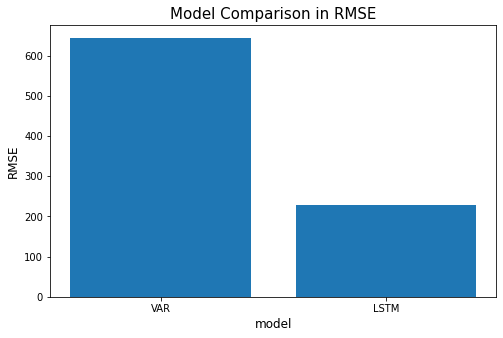

In [0]:
plt.figure(figsize=(8,5))
plt.bar(['VAR', 'LSTM'], [rmse_var, rmse_lstm])
plt.title('Model Comparison in RMSE', fontsize=15)
plt.xlabel('model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.show()

### Generate Predictions

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model_lstm.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(17,8))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

### Forecast

*forecasting on the training set*

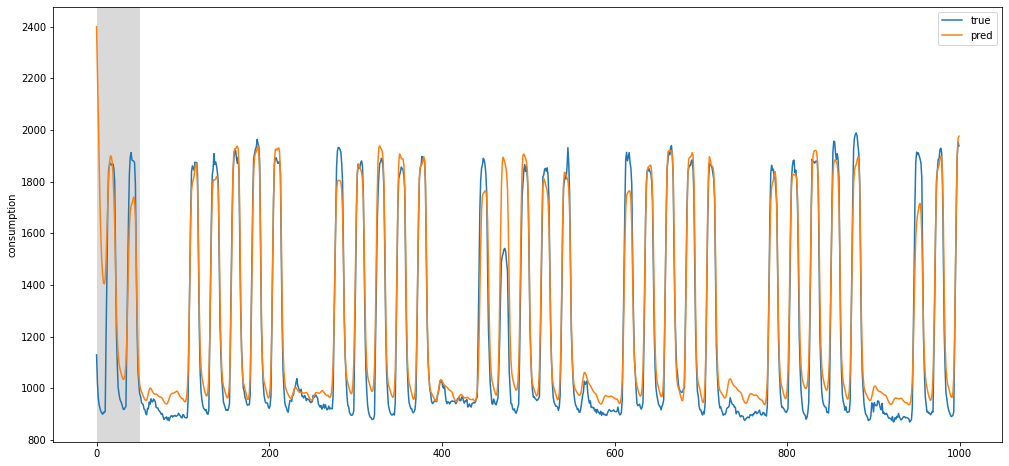

In [0]:
plot_comparison(start_idx=10000, length=1000, train=True)

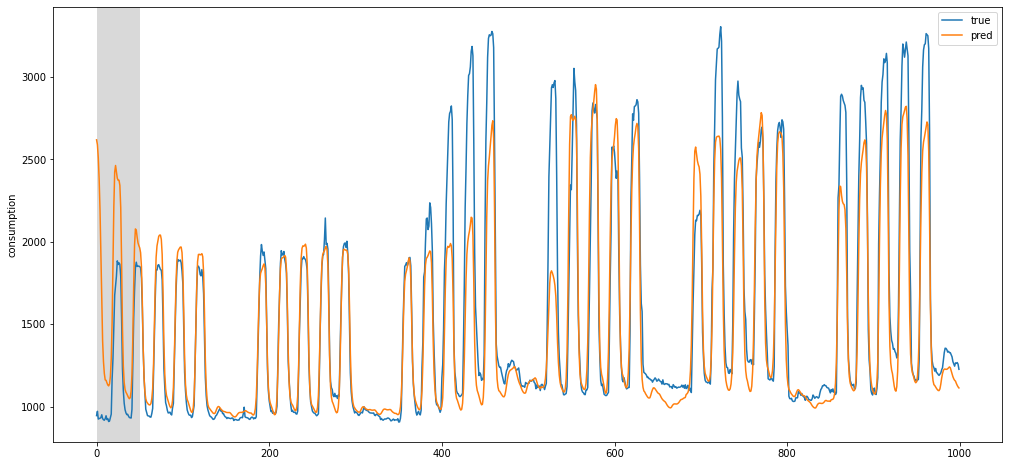

In [0]:
plot_comparison(start_idx=20000, length=1000, train=True)

*forecasting on the test set*

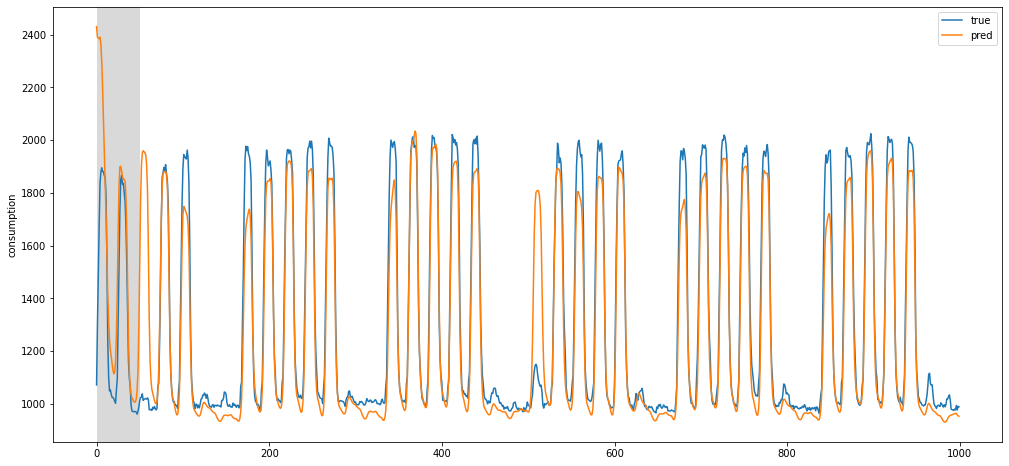

In [0]:
plot_comparison(start_idx=1000, length=1000, train=False)

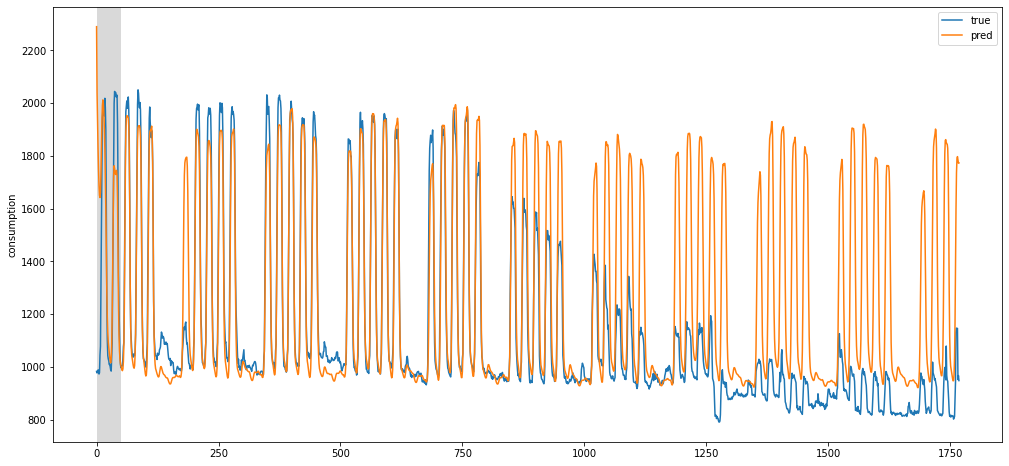

In [0]:
plot_comparison(start_idx=2000, length=2000, train=False)

### Save Model for Application


In [0]:
model_lstm.save(f'{root}/models/lstm_model.h5')
del model_lstm

## Support Vector Machine (SVM)

---

Cross Validation

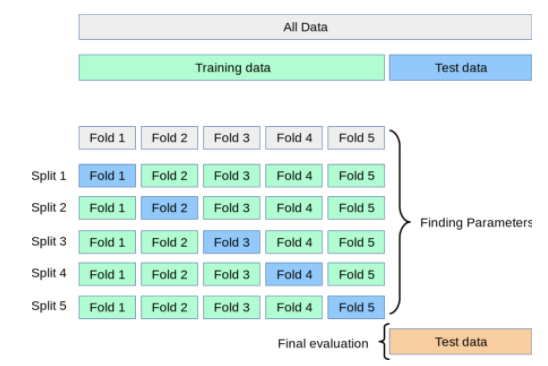

In [0]:
Image(filename=f'{root}/images/cv.png', width=400*1.5, height=300*1.5)

*Train and test data split*

In [0]:
target = 'consumption'
y = df_1CENTER[target]
X = df_1CENTER[df_1CENTER.columns.difference([target])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

*Hyper parameter tuning for the SVM model*

In [80]:
params = {
    'C': [0.1, 1, 10],
    'epsilon': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_grid = GridSearchCV(svm.SVR(), params, refit=True, verbose=2)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total= 1.4min
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total= 1.4min
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total= 1.4min
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total= 1.4min
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total= 1.4min
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  54.4s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  54.5s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  54.5s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 162.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'epsilon': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [81]:
#best score
print("Best score: %0.3f" % svm_grid.best_score_)
print("Best parameters set:")
best_parameters = svm_grid.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

clf = svm.SVR(kernel='poly', C=best_parameters['C'], epsilon=best_parameters['epsilon'])
clf.fit(X_train, y_train)
joblib.dump(clf, f'{root}/models/svm.sav')
pred_y_test = clf.predict(X_test)
print('rmse:', mean_squared_error(pred_y_test, y_test)**0.5) 

Best score: 0.650
Best parameters set:
	C: 10
	epsilon: 0.1
	kernel: 'poly'


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

['/content/drive/My Drive/EnerTrac Baselining/models/svm.sav']

rmse: 420.31299025442434


*Load the pre-stored SVM*

In [0]:
clf = joblib.load(f'{root}/models/svm.sav')
y_pred = clf.predict(X)
df_svm_all_seasons = pd.DataFrame()
df_svm_all_seasons['actual'] = y
df_svm_all_seasons['prediction'] = y_pred

In [0]:
df_svm_all_seasons.head()

actual   prediction
Interval End                            
2016-01-01 01:00:00   922.0  1028.095032
2016-01-01 02:00:00   923.0  1021.590624
2016-01-01 03:00:00   918.0  1014.455175
2016-01-01 04:00:00   913.0  1016.784760
2016-01-01 05:00:00   914.0  1073.124386

*Plot the prediction*

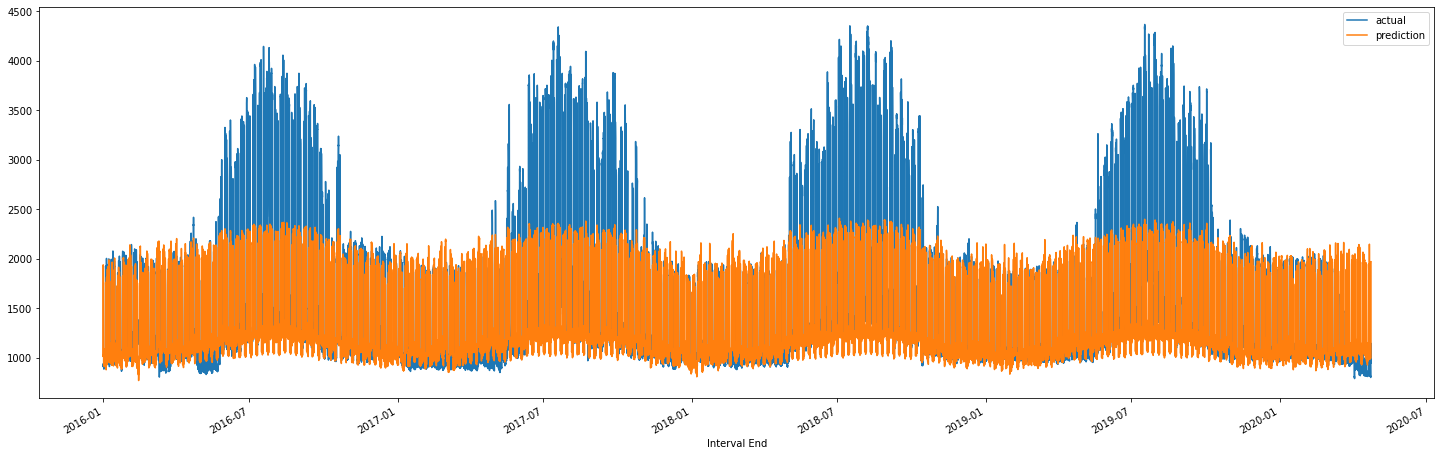

In [0]:
df_svm_all_seasons.plot(figsize=(25,8))
plt.show()

*The SVM model predicts the consumption is summertime extrodinarily off, therefore, it would be better to have saparate models to predict the consumptions in different seasons, i.e. summer vs not summer*

In [0]:
target = 'consumption'
df_1CENTER_summer = df_1CENTER[(df_1CENTER['is_summer']==1) | (df_1CENTER['is_spring']==1)]
y_summer = df_1CENTER_summer[target]
X_summer = df_1CENTER_summer[df_1CENTER_summer.columns.difference([target])]
X_summer_train, X_summer_test, y_summer_train, y_summer_test = train_test_split(X_summer, y_summer, test_size=0.1, random_state=42)

df_1CENTER_not_summer = df_1CENTER[(df_1CENTER['is_winter']==1) | (df_1CENTER['is_autum']==1)]
y_not_summer = df_1CENTER_not_summer[target]
X_not_summer = df_1CENTER_not_summer[df_1CENTER_not_summer.columns.difference([target])]
X_not_summer_train, X_not_summer_test, y_not_summer_train, y_not_summer_test = train_test_split(X_not_summer, y_not_summer, test_size=0.1, random_state=42)

In [44]:
params = {
    'C': [0.1, 1, 10],
    'epsilon': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_summer_grid = GridSearchCV(svm.SVR(), params, refit=True, verbose=2)
svm_summer_grid.fit(X_summer_train, y_summer_train)

svm_not_summer_grid = GridSearchCV(svm.SVR(), params, refit=True, verbose=2)
svm_not_summer_grid.fit(X_not_summer_train, y_not_summer_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.0s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  17.8s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  17.9s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  17.9s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.1s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.0s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.0s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.0s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 35.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'epsilon': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.7s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.6s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.6s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.6s
[CV] C=0.1, epsilon=1, kernel=rbf ....................................
[CV] ..................... C=0.1, epsilon=1, kernel=rbf, total=  18.6s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.1s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.1s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .................... C=0.1, epsilon=1, kernel=poly, total=  12.2s
[CV] C=0.1, epsilon=1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 37.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'epsilon': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

*Performance for the summer model*

In [45]:
#best score
print("Best score: %0.3f" % svm_summer_grid.best_score_)
print("Best parameters set:")
best_parameters_summer = svm_summer_grid.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters_summer[param_name]))

clf_summer = svm.SVR(kernel='poly', C=best_parameters_summer['C'], epsilon=best_parameters_summer['epsilon'])
clf_summer.fit(X_summer_train, y_summer_train)
joblib.dump(clf_summer, f'{root}/models/svm_summer.sav')
pred_y_summer_test = clf_summer.predict(X_summer_test)
print('rmse:', mean_squared_error(pred_y_summer_test, y_summer_test)**0.5) 

Best score: 0.674
Best parameters set:
	C: 10
	epsilon: 1
	kernel: 'poly'


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

['/content/drive/My Drive/EnerTrac Baselining/models/svm_summer.sav']

rmse: 518.0799960745666


*Performance for the not summer model*

In [46]:
#best score
print("Best score: %0.3f" % svm_not_summer_grid.best_score_)
print("Best parameters set:")
best_parameters_not_summer = svm_not_summer_grid.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters_not_summer[param_name]))

clf_not_summer = svm.SVR(kernel='poly', C=best_parameters_not_summer['C'], epsilon=best_parameters_not_summer['epsilon'])
clf_not_summer.fit(X_not_summer_train, y_not_summer_train)
joblib.dump(clf_not_summer, f'{root}/models/svm_not_summer.sav')
pred_y_not_summer_test = clf_not_summer.predict(X_not_summer_test)
print('rmse:', mean_squared_error(pred_y_not_summer_test, y_not_summer_test)**0.5) 

Best score: 0.718
Best parameters set:
	C: 10
	epsilon: 1
	kernel: 'poly'


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

['/content/drive/My Drive/EnerTrac Baselining/models/svm_not_summer.sav']

rmse: 254.94030227487437


*Predictions for the summertime model*

In [0]:
clf_summer = joblib.load(f'{root}/models/svm_summer.sav')
clf_not_summer = joblib.load(f'{root}/models/svm_not_summer.sav')

y_summer_pred = clf_summer.predict(X_summer)
y_not_summer_pred = clf_not_summer.predict(X_not_summer)

In [0]:
df_svm_summer = pd.DataFrame()
df_svm_summer['actual'] = y_summer
df_svm_summer['prediction'] = y_summer_pred

df_svm_not_summer = pd.DataFrame()
df_svm_not_summer['actual'] = y_not_summer
df_svm_not_summer['prediction'] = y_not_summer_pred

df_svm_sep_seasons = pd.concat([df_svm_summer, df_svm_not_summer])
df_svm_sep_seasons = df_svm_sep_seasons.sort_index()

*Clearly, something is off even by using a seasonal split, however, this doesn't mean that the model performs equally bad on other buildings*

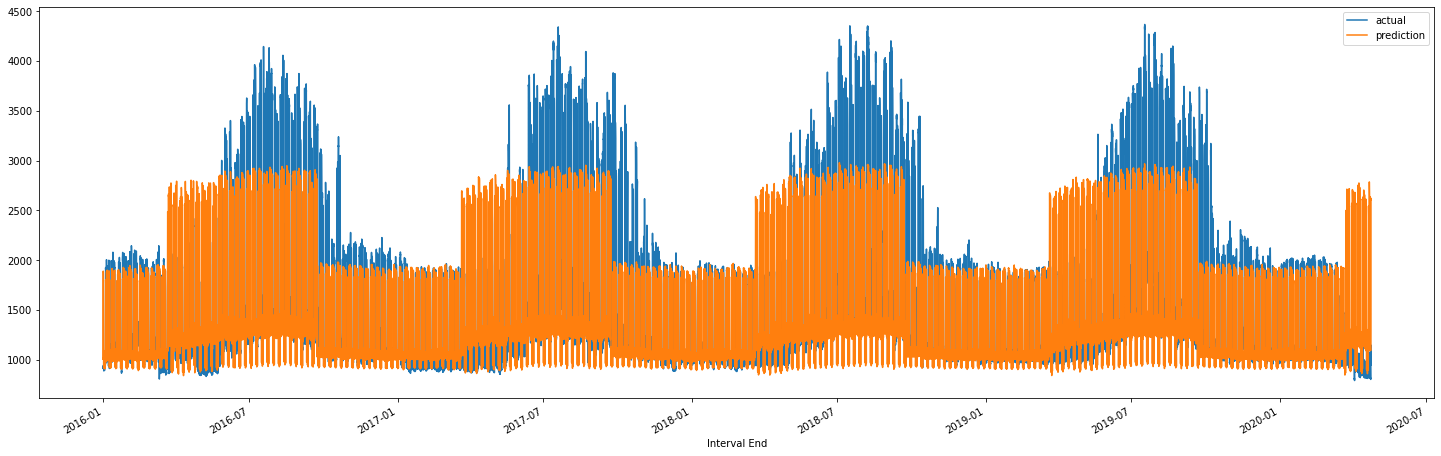

In [49]:
df_svm_sep_seasons.plot(figsize=(25,8))

## Quantile Regression Trees

*Exclude the Covid-19 period data for the random forests*

In [42]:
target = 'consumption'
df_1CENTER_no_covid = df_1CENTER[df_1CENTER.index<=pd.to_datetime('2020-03-15')]
y_nocovid = df_1CENTER_no_covid[[target]]
X_nocovid = df_1CENTER_no_covid[df_1CENTER_no_covid.columns.difference([target])]
X_nocovid_train, X_nocovid_test, y_nocovid_train, y_nocovid_test = train_test_split(X_nocovid, y_nocovid, test_size=0.2, random_state=42)

print(X_nocovid.columns, y_nocovid.columns)

Index(['day_of_week', 'derived_occ_dow', 'derived_occ_hod', 'dew_point_temp',
       'discomfort_index', 'dry_bulb_temp', 'hour_of_day', 'is_autum',
       'is_holiday', 'is_spring', 'is_summer', 'is_weekday', 'is_winter',
       'relative_humidity', 'thermal_mass_12', 'thermal_mass_3',
       'thermal_mass_5', 'thermal_mass_7', 'wet_bulb_temp'],
      dtype='object') Index(['consumption'], dtype='object')


In [43]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1)
rf.fit(X_nocovid_train, y_nocovid_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
y_nocovid_pred = rf.predict(X_nocovid_test)
print((mean_squared_error(y_nocovid_pred, y_nocovid_test))**0.5)

127.12051499398622


In [0]:
y_pred = rf.predict(X)
df_rf = pd.DataFrame()
df_rf['actual'] = y
df_rf['prediction'] = y_pred

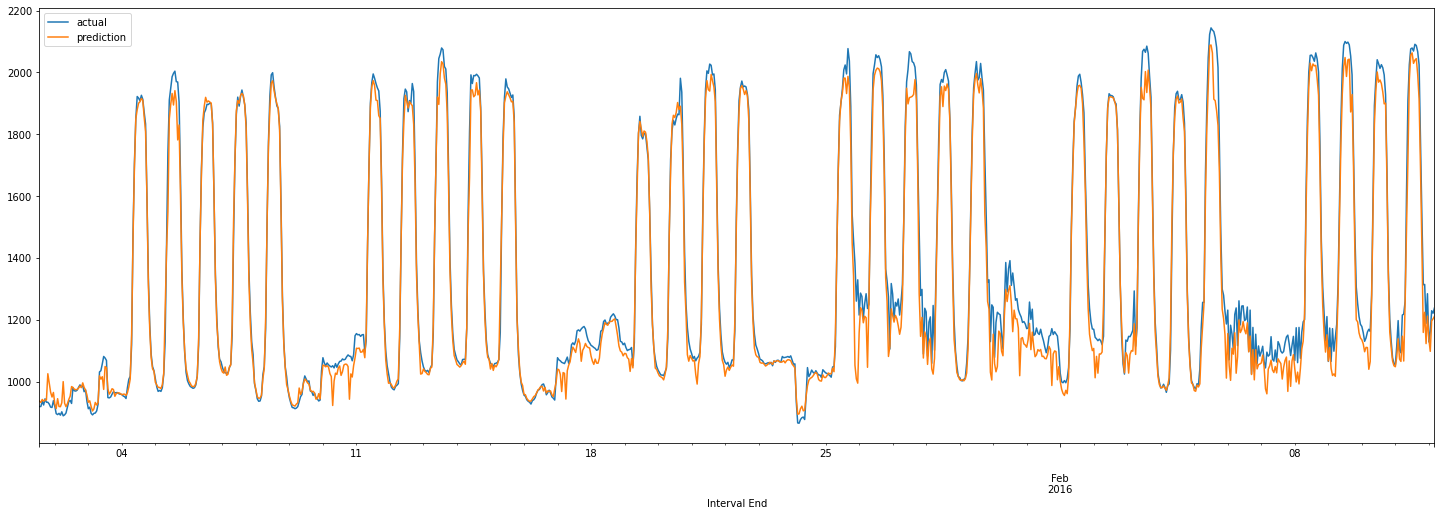

In [72]:
df_rf.head(1000).plot(figsize=(25,8))
plt.show()

*Check the accuracy of the quantile regression model*

In [51]:
def pred_ints(model, X, percentile=95):
  err_down = []
  err_up = []
  for x in range(X.shape[0]):
      preds = []
      for pred in model.estimators_:
          preds.append(pred.predict([X.iloc[x].values]))
      err_down.append(np.percentile(preds, (100-percentile)/2.))
      err_up.append(np.percentile(preds, 100-(100-percentile)/2.))
  return err_down, err_up

err_down, err_up = pred_ints(rf, X_test, percentile=90)
 
truth = y_test
correct = 0
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print(correct/len(truth))

0.9323966065747614


*Grid Search for tuning the random forest hyper-parameters*

In [0]:
param_rf = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'max_features': [2, 5, 10],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [500, 1000]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_rf, cv=3, verbose=2)
rf_grid.fit(X_nocovid_train, y_nocovid_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=  12.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=  12.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, total=  12.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 


*Feature Importance Graph*

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Feature Importance based on Random Forests Prediction')

Text(0.5, 0, 'feature importance')

Text(0, 0.5, 'features')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 <a list of 8 Text major ticklabel objects>)

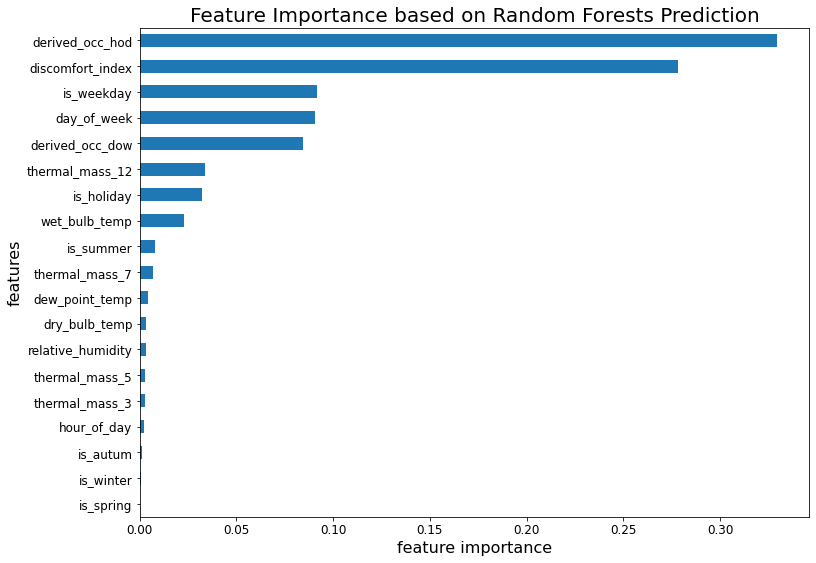

In [69]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
plt.figure(figsize=(12,9))
feat_importances.nsmallest(X.shape[1]).plot(kind='barh')
plt.title('Feature Importance based on Random Forests Prediction', fontsize=20)
plt.xlabel('feature importance', fontsize=16)
plt.ylabel('features', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

## Package the code into a module
----
*instead of pasting in a bulk of code like below into the cell of the jupyter notebook, the common and better practice is to put the code into a python script and import it as an external module. By doing this, not only the user of this notebook, but also others who want to use the functions of this module would be able to import the functions without double-writing the same code*


In [0]:
def load_enertrac_data(root, fn):
  """
  load basic Enertrac data given the root path and the file name
  of the enertrac data
  """
  df_1CENTER = pd.read_excel(f'{root}/data/{fn}', 
                             header=1, 
                             index_col=0,
                             sheet_name='Data') 

  df_1CENTER['DCAS 1 Centre Street - 490118259000005'] = df_1CENTER.iloc[:, 5:11].sum(axis=1)
  df_1CENTER['DCAS 1 Centre Street - 490118259100011'] = df_1CENTER.iloc[:, [12]].sum(axis=1)
  df_1CENTER['DCAS 1 Centre Street (kW)'] = df_1CENTER.iloc[:, [4,11]].sum(axis=1)
  df_1CENTER = df_1CENTER[['Dry-Bulb F', 'Wet-Bulb F', 'Dew-Point F', 'DCAS 1 Centre Street (kW)']]
  df_1CENTER.rename(columns={'Dry-Bulb F': 'dry_bulb_temp',
                             'Wet-Bulb F': 'wet_bulb_temp',
                             'Dew-Point F': 'dew_point_temp',
                             'DCAS 1 Centre Street (kW)': 'consumption'},
                    index={'Interval End': 'time'},
                    inplace=True)

  df_1CENTER = df_1CENTER.dropna()

  return df_1CENTER

def feature_engineering(df_1CENTER):
  """
  read in the loaded enertrac data and added
  engineered features in addtion to the original
  enertrac features
  """

  df_1CENTER['discomfort_index'] = 0.4*(df_1CENTER.dry_bulb_temp+df_1CENTER.wet_bulb_temp)+15

  def calc_rh(row):
    dry_bulb_temp = row['dry_bulb_temp']*units.degF
    wet_bulb_temp = row['wet_bulb_temp']*units.degF
    atmos_pressure = 101325*units.pascal
    relative_humidity = relative_humidity_wet_psychrometric(dry_bulb_temperature=dry_bulb_temp,
                                                            web_bulb_temperature=wet_bulb_temp,
                                                            pressure=atmos_pressure)
    return relative_humidity

  df_1CENTER['relative_humidity'] = df_1CENTER.apply(calc_rh, axis=1).astype(float)

  df_1CENTER['day_of_week'] = df_1CENTER.index
  df_1CENTER['day_of_week'] = df_1CENTER['day_of_week'].apply(lambda x: int(x.weekday()))

  df_1CENTER['hour_of_day'] = df_1CENTER.index
  df_1CENTER['hour_of_day'] = df_1CENTER['hour_of_day'].apply(lambda x: int(x.hour))

  def derived_occ_dow(row):
    dow = row['day_of_week'] # day of week
    return occ_dow[dow]

  occ_dow = dict(df_1CENTER.groupby(['day_of_week'])[['consumption']].mean().reset_index().values)
  df_1CENTER['derived_occ_dow'] = df_1CENTER.apply(derived_occ_dow, axis=1)

  def derived_occ_hod(row):
    hod = row['hour_of_day'] # hour of day
    return occ_hod[hod]

  occ_hod = dict(df_1CENTER.groupby(['hour_of_day'])[['consumption']].mean().reset_index().values)
  df_1CENTER['derived_occ_hod'] = df_1CENTER.apply(derived_occ_hod, axis=1)

  def check_week_day(row):
    dow = row['day_of_week']
    if dow in range(5):
      return 1
    return 0

  df_1CENTER['is_weekday'] = df_1CENTER.apply(check_week_day, axis=1)

  return df_1CENTER

def prepare_data(df_1CENTER):
  """
  train, validation and test data split
  """
  target_names = ['consumption']
  shift_days = 2
  shift_steps = shift_days*24

  df_1CENTER_target = df_1CENTER[target_names].shift(-shift_steps)
  x_data = df_1CENTER.values[0:-shift_steps]
  y_data = df_1CENTER_target.values[0:-shift_steps]
  indices = df_1CENTER[0:-shift_steps].index

  num_data = len(x_data)
  train_split = 0.9
  num_train = int(train_split*num_data)
  num_test = num_data - num_train

  x_train = x_data[0:num_train]
  x_test = x_data[num_train:]

  y_train = y_data[0:num_train]
  y_test = y_data[num_train:]

  validation_split = 0.1
  num_validation = int(validation_split*num_train)
  num_train = num_train - num_validation

  x_validation = x_train[num_train:]
  x_train = x_train[:num_train]

  y_validation = y_train[num_train:]
  y_train = y_train[:num_train]

  num_x_signals = x_data.shape[1]
  num_y_signals = y_data.shape[1]

  return x_data, \
         x_train, \
         x_validation, \
         x_test, \
         y_data, \
         y_train, \
         y_validation, \
         y_test, \
         num_x_signals, \
         num_y_signals, \
         num_train, \
         indices

def scale_data(x_data,
               x_train, 
               x_validation,
               x_test,
               y_data, 
               y_train, 
               y_validation,
               y_test):
  """
  use min max scaling method to scale the data
  """

  x_scaler = MinMaxScaler()
  x_data_scaled = x_scaler.fit_transform(x_data)
  x_train_scaled = x_scaler.fit_transform(x_train)
  x_test_scaled = x_scaler.transform(x_test)
  x_validation_scaled = x_scaler.transform(x_validation)

  y_scaler = MinMaxScaler()
  y_data_scaled = y_scaler.fit_transform(y_data)
  y_train_scaled = y_scaler.fit_transform(y_train)
  y_test_scaled = y_scaler.transform(y_test)
  y_validation_scaled = y_scaler.transform(y_validation)

  return x_data_scaled, \
         x_train_scaled, \
         x_validation_scaled, \
         x_test_scaled, \
         y_data_scaled, \
         y_train_scaled, \
         y_validation_scaled, \
         y_test_scaled, \
         y_scaler

def load_lstm_model(root, model_name):
  """
  load the pre-stored LSTM model
  """

  def loss_mse_warmup(y_true, y_pred):
    warmup_steps = 50
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))
    return mse

  def NRMSD(y_true, y_pred):
    return sqrt(mean(square(y_pred-y_true))) / mean(y_true)

  def mean_forecast_error(y_true, y_pred):
    return mean(y_true-y_pred)

  model_lstm = load_model(f'{root}/models/{model_name}', 
                          custom_objects={'loss_mse_warmup': loss_mse_warmup, 
                                          'NRMSD': NRMSD,
                                          'mean_forecast_error': mean_forecast_error})

  return model_lstm

def output_predictions(root, fn, model_name):
  """
  generate final predictions for LSTM
  """
  df_1CENTER = load_enertrac_data(root, fn)
  df_1CENTER = feature_engineering(df_1CENTER)

  x_data, \
  x_train, \
  x_validation, \
  x_test, \
  y_data, \
  y_train, \
  y_validation, \
  y_test, \
  num_x_signals, \
  num_y_signals, \
  num_train, \
  indices = prepare_data(df_1CENTER)

  x_data_scaled, \
  x_train_scaled, \
  x_validation_scaled, \
  x_test_scaled, \
  y_data_scaled, \
  y_train_scaled, \
  y_validation_scaled, \
  y_test_scaled, \
  y_scaler = scale_data(x_data,
                        x_train, 
                        x_validation,
                        x_test, 
                        y_data,
                        y_train, 
                        y_validation,
                        y_test)
  
  x = np.expand_dims(x_data_scaled, axis=0)
  model_lstm = load_lstm_model(root, model_name)

  y_pred = model_lstm.predict(x)
  y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

  d = {
      'predicted': y_pred_rescaled[:,0],
      'actual': y_data[:,0],
  }

  results = pd.DataFrame(d, index=indices)
  results.index.rename('time', inplace=True)
  return results

root = r'/content/drive/My Drive/EnerTrac Baselining'
fn = 'RTM_Export_DCAS 1 Centre Street_2016-01-01_2020-04-23_20200423181146.xlsx'
model_name = 'lstm_model.h5'
drive.mount('/content/drive')
results = output_predictions(root, fn, model_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Demo / Widget

---

*This is an interactive widget for you to play around*

In [0]:
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2020-04-21')

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %m/%d/%y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '1600px'}
)

def demo(building, 
         model,
         predicted, 
         actual,
         date_range):
  start_date, end_date =date_range[0], date_range[1]
  pred = results[start_date:end_date]

  warmup = 2
  if predicted and actual:
    ax = pred[['actual', 'predicted']].plot(figsize=(30,8))
    plt.axvspan(*pd.to_datetime([start_date, 
                                 start_date+timedelta(days=warmup)]), 
                facecolor='black', 
                alpha=0.15)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Consumption (kW)', fontsize=20)
    plt.legend(loc=0, prop={'size': 20})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
  elif predicted:
    ax = pred[['predicted']].plot(figsize=(30,8), color='C1')
    plt.axvspan(*pd.to_datetime([start_date, 
                                 start_date+timedelta(days=warmup)]), 
                facecolor='black', 
                alpha=0.15)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Consumption (kW)', fontsize=20)
    plt.legend(loc=0, prop={'size': 20})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
  elif actual:
    ax = pred[['actual']].plot(figsize=(30,8), color='C0')
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Consumption (kW)', fontsize=20)
    plt.legend(loc=0, prop={'size': 20})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
  else:
    print('')

widgets.interact(
    demo,
    building=['DCAS 1 Centre St.'],
    model=['LSTM'],
    predicted=False,
    actual=False,
    date_range=selection_range_slider,
)

interactive(children=(Dropdown(description='building', options=('DCAS 1 Centre St.',), value='DCAS 1 Centre St…

<function __main__.demo>